In [1]:
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm
import platform
import seaborn as sns  
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [ ]:
# CSV 파일 읽기 (파일 이름과 경로는 실제 환경에 맞게 바꿔주세요)
train = pd.read_csv('train.csv', encoding='utf-8')
meta
# 데이터 기본 정보 확인
print(train.info())
print(train.head())

# 운영체제별 한글 폰트 경로 설정
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕
elif platform.system() == 'Darwin':
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'  # Mac 한글폰트
else:
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 리눅스 나눔고딕 (설치 필요)
    
# 폰트 적용
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB
None
    item_id  year  month  seq  type   hs4    weight  quantity     value
0  DEWLVASR  2022      1  1.0     1  3038   14858.0       0.0   32688.0
1  ELQGMQWE  2022      1  1.0     1  2002   62195.0       0.0  110617.0
2  AHMDUILJ  2022      1  1.0     1  2102   18426.0       0.0   72766.0
3  XIPPENFQ  2022      1  1.0     1  2501   20426.0       0.0   11172.0
4  FTSVTTSR  2022      1  1.0     

무게가 0인데 가치가 있는 경우: 예를 들어, 전자문서, 소프트웨어, 라이선스, 지적재산권과 같이 물리적 무게가 거의 없거나 0에 가까운 품목도 무역 거래가 이루어지며, 이 경우 가치만 존재합니다.

가치가 0인데 무게가 있는 경우: 시료용 샘플, 저가 물품, 또는 신고 오류 등으로 무게만 입력되고 가치가 누락된 경우가 있을 수 있습니다.

데이터 수집 및 신고 오류: 무역 통관 과정에서 실무자가 실수하거나 시스템 문제로 무게 또는 가치 데이터가 누락되거나 잘못 기록될 수 있습니다.

비관세장벽 및 제도적 이유: 일부 수입품에 대해 과세 목적이나 통계 분류상 특수한 처리로 인해 무게나 가치가 비정상적으로 처리될 가능성도 존재합니다.

In [3]:
# 논리 불일치 데이터 탐색 및 제거

mask_value0_weight_pos = (train['value'] == 0) & (train['weight'] > 0)
mask_weight0_value_pos = (train['weight'] == 0) & (train['value'] > 0)
inconsistent_rows = train[mask_value0_weight_pos | mask_weight0_value_pos]

print(f'논리 불일치 행 수: {len(inconsistent_rows)}')

# 불일치 데이터 제거
train = train[~(mask_value0_weight_pos | mask_weight0_value_pos)].reset_index(drop=True)
print(f'정제 후 데이터 shape: {train.shape}')

논리 불일치 행 수: 301
정제 후 데이터 shape: (10535, 9)


item_id     0
year        0
month       0
seq         0
type        0
hs4         0
weight      0
quantity    0
value       0
dtype: int64


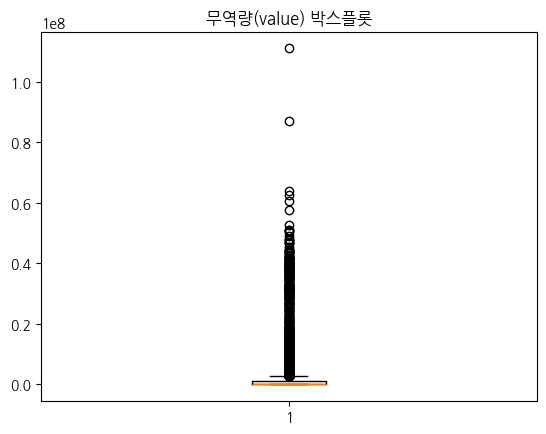

In [4]:
# 결측치 및 이상치 확인

print(train.isnull().sum())

import matplotlib.pyplot as plt
plt.boxplot(train['value'])
plt.title('무역량(value) 박스플롯')
plt.show()


In [5]:
# 품목별 월별 시계열 누락 데이터 확인 및 보완
# 누락된 월이 있다면 0 또는 적절한 값으로 채워 시계열 연속성을 보장해야 함
all_months = pd.date_range(start='2022-01-01', end='2025-07-01', freq='MS')

def fill_missing_months(group):
    item_id = group.name 
    # year, month로 date 생성
    group['date'] = pd.to_datetime(group[['year', 'month']].assign(day=1))
    # 중복된 date 제거 (가장 처음 행만 남김)
    group = group.drop_duplicates(subset='date')
    # date를 인덱스로 설정 후 전체 기간 재색인
    group = group.set_index('date').reindex(all_months).fillna(0).reset_index()
    group['year'] = group['index'].dt.year
    group['month'] = group['index'].dt.month
    group = group.drop(columns=['index'])
    group['item_id'] = item_id
    # 정리 후 반환
    return group

train_filled = train.groupby('item_id', group_keys=False).apply(fill_missing_months, include_groups=False).reset_index(drop=True)
print(f'보완 후 데이터 shape: {train_filled.shape}')
print(train_filled.head())


보완 후 데이터 shape: (4300, 9)
   year  month  seq  type     hs4   weight  quantity    value   item_id
0  2022      1  2.0   1.0  4810.0  17625.0       0.0  14276.0  AANGBULD
1  2022      2  3.0   1.0  4810.0  67983.0       0.0  52347.0  AANGBULD
2  2022      3  2.0   1.0  4810.0  69544.0       0.0  53549.0  AANGBULD
3  2022      4  0.0   0.0     0.0      0.0       0.0      0.0  AANGBULD
4  2022      5  2.0   1.0  4810.0  34173.0       0.0  26997.0  AANGBULD


In [6]:
# 품목별 시계열 통계 및 변화율 계산
# 각 품목별 무역량(value)에 대해 평균, 표준편차, 월별 변화율(증감률)을 산출해 시계열 특성 강화

train_filled['value_change_rate'] = train_filled.groupby('item_id')['value'].transform(lambda x: x.pct_change().fillna(0))
stats = train_filled.groupby('item_id')['value'].agg(['mean', 'std']).reset_index()
print(stats.head())


    item_id          mean           std
0  AANGBULD  6.519807e+04  1.221743e+05
1  AHMDUILJ  4.429323e+04  3.808460e+04
2  ANWUJOKX  6.849093e+03  1.629458e+04
3  APQGTRMF  1.426705e+05  1.150632e+05
4  ATLDMDBO  2.038085e+07  1.996461e+07


HS 코드(4자리)는 국제 무역에서 품목을 분류하는 체계로, 일반적으로 대분류(2자리), 중분류(4자리), 소분류(6자리 이상)로 세분화

주어진 hs4 4자리 코드를 바탕으로 **대분류(2자리)**와 중분류(4자리)를 도출해 분석에 활용

품목별 공행성 분석 전에 상위 분류별로 묶어보면 비슷한 무역 패턴, 공급망 특성을 가진 그룹이 나올 수 있어 노이즈가 줄고 인사이트 확보에 도움

  major_cls           mean            std
0        00       0.000000       0.000000
1        12  200026.953488  241044.313837
2        20  122789.465116   94057.475752
3        21   44293.232558   38084.596457
4        25  166327.398438  341347.380922


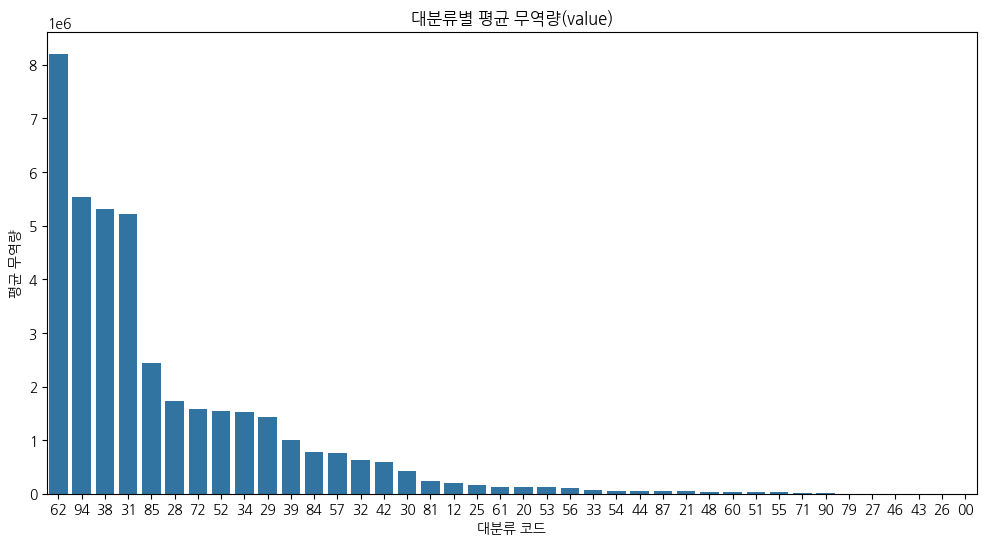

In [7]:
# hs4를 문자열로 변환하고 4자리 맞춤 (필요 시)
train_filled['hs4_str'] = train_filled['hs4'].astype(int).astype(str).str.zfill(4)

# 대분류(2자리 접두어)
train_filled['major_cls'] = train_filled['hs4_str'].str[:2]

# 중분류는 4자리 그대로 사용
train_filled['mid_cls'] = train_filled['hs4_str']

# 대분류별 무역량(value) 평균 및 표준편차
major_stats = train_filled.groupby('major_cls')['value'].agg(['mean', 'std']).reset_index()
print(major_stats.head())

# 시각화: 대분류별 평균 무역량
plt.figure(figsize=(12,6))
sns.barplot(data=major_stats.sort_values('mean', ascending=False), x='major_cls', y='mean')
plt.title('대분류별 평균 무역량(value)')
plt.xlabel('대분류 코드')
plt.ylabel('평균 무역량')
plt.show()

In [8]:
# HS4 4자리별 총 무역량
hs4_total = train_filled.groupby('hs4')['value'].sum().sort_values(ascending=False)
print("HS4별 총 무역량 상위 10개:")
print(hs4_total.head(10))

# 누적 비율 계산
hs4_df = pd.DataFrame({
    'hs4': hs4_total.index,
    'value': hs4_total.values
})
hs4_df['cum_sum'] = hs4_df['value'].cumsum()
hs4_df['cum_perc'] = (hs4_df['cum_sum'] / hs4_df['value'].sum()) * 100

print("\n전체 무역량의 80%를 차지하는 HS4 코드:")
print(hs4_df[hs4_df['cum_perc'] <= 80])


HS4별 총 무역량 상위 10개:
hs4
3824.0    1.553574e+09
2814.0    8.763765e+08
8505.0    5.097235e+08
3102.0    4.488151e+08
3815.0    4.075558e+08
6211.0    3.529206e+08
8501.0    2.527834e+08
9403.0    2.378176e+08
2811.0    2.364209e+08
7207.0    1.274464e+08
Name: value, dtype: float64

전체 무역량의 80%를 차지하는 HS4 코드:
      hs4         value       cum_sum   cum_perc
0  3824.0  1.553574e+09  1.553574e+09  25.494405
1  2814.0  8.763765e+08  2.429950e+09  39.875889
2  8505.0  5.097235e+08  2.939674e+09  48.240536
3  3102.0  4.488151e+08  3.388489e+09  55.605666
4  3815.0  4.075558e+08  3.796045e+09  62.293725
5  6211.0  3.529206e+08  4.148965e+09  68.085211
6  8501.0  2.527834e+08  4.401749e+09  72.233429
7  9403.0  2.378176e+08  4.639567e+09  76.136055


| 코드 | 품목군명          | 코드 | 품목군명            |
|-------|------------------|-------|--------------------|
| 00    | 살아있는 동물      | 44    | 목재 및 목재제품     |
| 12    | 기름 및 기름 씨앗  | 46    | 짚, 바구니류 등      |
| 20    | 채소, 과일, 견과류 | 51    | 양모 및 면          |
| 21    | 식료품 및 음료      | 52    | 면                  |
| 25    | 광물성 연료, 왁스  | 53    | 기타 식물성 섬유     |
| 26    | 광석 및 광물       | 54    | 합성 섬유           |
| 27    | 광물성 연료 및 정유 | 55    | 합성 섬유           |
| 28    | 무기 화학품 및 동위원소 | 56    | 기타 직물용 섬유     |
| 29    | 유기화학품         | 57    | 직물용 섬유실        |
| 30    | 의약품             | 60    | 편직물              |
| 31    | 비료               | 61    | 의류 및 의복 액세서리|
| 32    | 염료, 타닌, 염료용 물질 | 62    | 의류 및 액세서리 (편물 제외) |
| 33    | 향료 및 화장품     | 71    | 귀금속, 보석        |
| 38    | 비누, 유기표면활성제| 72    | 철강                |
| 39    | 플라스틱 및 플라스틱 제품 | 79    | 아연 및 그 제품      |
| 42    | 가죽, 여행용품     | 81    | 조립금속 및 기타     |
| 43    | 모피               | 84    | 기계류              |
| 48    | 종이 및 종이제품  | 85    | 전기기기            |
| 49    | 도서 및 인쇄물     | 87    | 차량 및 관련 부품   |
| 50    | 실크               | 90    | 광학기기 및 계측기기|
| 54    | 합성 섬유          | 94    | 가구, 조명 및 기타   |


In [9]:
print(train_filled['major_cls'].unique())

['48' '00' '21' '44' '81' '28' '55' '32' '90' '31' '94' '62' '56' '30'
 '38' '20' '34' '79' '87' '25' '27' '71' '85' '60' '12' '46' '39' '51'
 '84' '72' '57' '54' '33' '42' '29' '26' '43' '61' '53' '52']


62, 94, 38, 31번 대분류: 평균 무역량이 매우 높아, 이 영역의 품목들이 전체 무역에서 많은 비중을 차지함을 의미

 | 62    | 의류 및 액세서리 (편물 제외) 

 편물(knit, 니트): 실을 고리 형식으로 짜는 방식으로, 뜨개질로 만든 목도리처럼 잘 늘어나는 성질이 있습니다. → HS 61류에 분류'
 예: 티셔츠, 니트, 후드티 등
 직물(woven): 날실과 씨실을 직각으로 교차해서 짠 천으로, 편물이 아닌 일반 천입니다. → HS 62류에 분류
 계절별 패턴, 패션 트렌드 변화에 민감하므로 월별 변동 추적 중요
 공행성 예상: 같은 의류군(61류 편물 의류)이나 섬유 관련 품목(52~60류)과 연관성 높을 가능성

 | 94    | 가구, 조명 및 기타 
 특징: 내구재이므로 경기 변동, 부동산 경기와 연동 가능성
 공행성 예상: 건설/인테리어 관련 품목(목재 44류, 플라스틱 39류 등)과 연관

 | 38    | 비누, 유기표면활성제 
 특징: 산업 원자재 및 소비재의 중간적 성격
 공행성 예상: 화학품군(28, 29류 무기/유기화학품)과 높은 연관성

 | 31    | 비료             
 특징: 농업 생산과 직결되며 계절성(파종기, 수확기) 영향 큼
 공행성 예상: 농산물 관련 품목, 화학품(28류 무기화학품) 등과 연관 


In [10]:
# 품목 간 시계열 상관관계 분석 (공행성 탐색 기초)
# 월별 pivot 테이블 생성 (품목별 value)
pivot_df = train_filled.pivot_table(
    index=['year', 'month'], 
    columns='item_id', 
    values='value', 
    fill_value=0
)

# 상관계수 매트릭스 계산
corr_matrix = pivot_df.corr()

# 상관계수 절대값 기준 상위 쌍 추출
import numpy as np
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'item_A': corr_matrix.columns[i],
            'item_B': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', ascending=False)
print(corr_df.head(20))  # 상관도 높은 상위 20쌍

        item_A    item_B  correlation
3263  KFQSHBNH  RJCAXSGH     0.933778
3379  LLHREMKS  RUVXNNVA     0.847964
3295  KFQSHBNH  ZKENOUDA     0.772425
2313  FTSVTTSR  XIIEJNEE     0.730613
4262  QSDCUCLB  UGEQLMXM     0.693251
4420  RJCAXSGH  ZKENOUDA     0.678749
979   BTMOEMEP  LRVGFDFM     0.650141
3332  KJNSOAHR  UGEQLMXM     0.639956
2250  FTSVTTSR  GIKPEWTY     0.631408
1517  DJBLNPNC  SAAYMURU     0.628102
920   BSRMSVTC  SUOYXCHP     0.622602
1952  FDXPMYGF  GIKPEWTY     0.617965
1623  DNMPSKTB  XUOIQPFL     0.615778
4302  QVLMOEYE  VBYCLTYZ     0.612083
2504  GKQIJYDH  RUVXNNVA     0.603144
3292  KFQSHBNH  YSYHGLQK     0.593918
4210  QRKRBYJL  QVLMOEYE     0.593907
1836  EVBVXETX  RJGPVEXX     0.591643
3998  OKMBFVKS  XUOIQPFL     0.581296
2635  GYHKIVQT  QVLMOEYE     0.579055


### 왜 Lag가 중요한가?
무역에서는 공급망 관계나 산업 연쇄 효과 때문에 시차가 발생합니다:

원자재 → 완제품: 원자재(예: 화학품) 수입 증가 → 1~2개월 후 완제품(예: 가구, 의류) 수입 증가

계절성: 특정 품목 수입 증가 → 몇 개월 후 관련 품목 수입 증가

경제 지표: 경기 변화가 품목별로 다른 시차를 두고 영향을 줌

### 대회에서의 활용
Lag 0 (동시 공행성): 같은 달에 함께 움직임 → 공행성 판별에는 유효하지만, 예측에는 제한적

Lag 1~3 (선후행 관계): 선행 품목의 현재 데이터로 후행 품목의 미래(1~3개월 후)를 예측 가능 → 예측 모델에 유리

In [11]:
# 시차(lag) 교차상관 분석 (선후행 관계 탐색)
from scipy.stats import pearsonr

def cross_correlation_lag(series_A, series_B, max_lag=3):
    """시차별 상관계수 계산"""
    results = {}
    for lag in range(0, max_lag+1):
        if lag == 0:
            corr, _ = pearsonr(series_A, series_B)
        else:
            corr, _ = pearsonr(series_A[:-lag], series_B[lag:])
        results[lag] = corr
    return results

# 예시: 특정 두 품목 간 시차 상관
item_A_series = pivot_df['KFQSHBNH']
item_B_series = pivot_df['RJCAXSGH']
lag_corr = cross_correlation_lag(item_A_series, item_B_series, max_lag=3)
print(lag_corr)


{0: np.float64(0.9337779009208362), 1: np.float64(0.7583920434967101), 2: np.float64(0.6959813159135366), 3: np.float64(0.7673196812176807)}


Lag 0이 가장 높으므로 두 품목은 같은 달에 함께 움직이는 동시성 공행성이 강함

다만 Lag 3에서도 상관이 높아 복잡한 시차 패턴이 존재할 가능성이 있음

이는 선후행 관계라기보다는 동조 변동에 가까움

In [12]:
# 모든 고상관 쌍에 대해 시차 교차상관 계산
def find_lead_lag_pairs(corr_df, pivot_df, top_n=20, max_lag=3):
    results = []
    for idx, row in corr_df.head(top_n).iterrows():
        item_A = row['item_A']
        item_B = row['item_B']
        
        series_A = pivot_df[item_A]
        series_B = pivot_df[item_B]
        
        lag_corr = cross_correlation_lag(series_A, series_B, max_lag=max_lag)
        
        # lag 0 대비 lag 1~2가 높은지 확인
        best_lag = max(lag_corr, key=lag_corr.get)
        
        results.append({
            'item_A': item_A,
            'item_B': item_B,
            'corr_lag0': lag_corr[0],
            'best_lag': best_lag,
            'best_corr': lag_corr[best_lag]
        })
    
    return pd.DataFrame(results)

lead_lag_df = find_lead_lag_pairs(corr_df, pivot_df, top_n=50)
# Lag 1~3이 최적인 쌍 필터링
lead_lag_pairs = lead_lag_df[lead_lag_df['best_lag'] > 0]
print(lead_lag_pairs.head(20))

      item_A    item_B  corr_lag0  best_lag  best_corr
16  QRKRBYJL  QVLMOEYE   0.593907         2   0.665094


QRKRBYJL → QVLMOEYE (Lag 2)
Lag 0: 0.594

Lag 2: 0.665 (최고)

해석: QRKRBYJL 품목이 변화한 후 2개월 뒤 QVLMOEYE가 따라 움직이는 선후행 관계

활용: QRKRBYJL의 현재 데이터로 QVLMOEYE의 2개월 후 무역량 예측 가능

나머지 쌍들
대부분 Lag 0이 최고 → 동시성 공행성

이는 두 품목이 같은 경제 요인, 산업 트렌드에 동시에 반응함을 의미

대회 규칙상 "공행성 쌍"을 판별하는 것이므로, 동시성(Lag 0)도 공행성의 일종 

다만 예측 시에는:

선행 품목의 현재 달 데이터로 후행 품목의 다음 달을 예측

또는 두 품목 모두 같은 외부 요인(경기, 계절)에 영향받으므로 시계열 특징 공유 전략

In [13]:
# 상위 50~100개 쌍으로 확대
lead_lag_df = find_lead_lag_pairs(corr_df, pivot_df, top_n=100, max_lag=3)
lead_lag_pairs = lead_lag_df[lead_lag_df['best_lag'] > 0]
print(f"선후행 쌍 개수: {len(lead_lag_pairs)}")
print(lead_lag_pairs.sort_values('best_corr', ascending=False).head(20))


선후행 쌍 개수: 9
      item_A    item_B  corr_lag0  best_lag  best_corr
61  ATLDMDBO  BTMOEMEP   0.467754         1   0.792072
87  DNMPSKTB  OGAFEHLU   0.436788         2   0.687565
16  QRKRBYJL  QVLMOEYE   0.593907         2   0.665094
71  LRVGFDFM  OGAFEHLU   0.454512         2   0.620242
68  ATLDMDBO  UXSPKBJR   0.459320         3   0.582287
72  JPBRUTWP  QVLMOEYE   0.453458         2   0.535816
76  OGAFEHLU  SDWAYPIK   0.447762         2   0.495840
97  ELQGMQWE  RJCAXSGH   0.423666         1   0.490643
79  OGAFEHLU  OKMBFVKS   0.444025         2   0.467714


In [14]:
# 품목 정보 추출
item_info = train_filled.groupby('item_id').agg({
    'hs4': 'first',
    'major_cls': 'first', # 대분류
    'value': 'mean'  # 평균 무역량
}).reset_index()

# 선후행 쌍에 정보 추가
lead_lag_pairs_info = lead_lag_pairs.merge(
    item_info.rename(columns={
        'item_id': 'item_A', 
        'hs4': 'hs4_A', 
        'major_cls': 'major_A',
        'value': 'mean_value_A'
    }),
    on='item_A'
).merge(
    item_info.rename(columns={
        'item_id': 'item_B', 
        'hs4': 'hs4_B', 
        'major_cls': 'major_B',
        'value': 'mean_value_B'
    }),
    on='item_B'
)

print(lead_lag_pairs_info[['item_A', 'item_B', 'best_lag', 'best_corr', 'major_A', 'major_B']])


     item_A    item_B  best_lag  best_corr major_A major_B
0  QRKRBYJL  QVLMOEYE         2   0.665094      28      42
1  ATLDMDBO  BTMOEMEP         1   0.792072      28      31
2  ATLDMDBO  UXSPKBJR         3   0.582287      28      32
3  LRVGFDFM  OGAFEHLU         2   0.620242      31      72
4  JPBRUTWP  QVLMOEYE         2   0.535816      39      42
5  OGAFEHLU  SDWAYPIK         2   0.495840      72      72
6  OGAFEHLU  OKMBFVKS         2   0.467714      72      57
7  DNMPSKTB  OGAFEHLU         2   0.687565      28      72
8  ELQGMQWE  RJCAXSGH         1   0.490643      20      00


### 주요 패턴 해석
순위	선행 품목	후행 품목	Lag	상관	선행 산업	후행 산업	해석

1	ATLDMDBO	BTMOEMEP	1	0.792	28 (무기화학품)	31 (비료)	화학품 → 비료

2	DNMPSKTB	OGAFEHLU	2	0.688	28 (무기화학품)	72 (철강)	화학품 → 철강

3	QRKRBYJL	QVLMOEYE	2	0.665	28 (무기화학품)	42 (가죽제품)	화학품 → 가죽

4	LRVGFDFM	OGAFEHLU	2	0.620	31 (비료)	72 (철강)	비료 → 철강

5	ATLDMDBO	UXSPKBJR	3	0.582	28 (무기화학품)	32 (염료)	화학품 → 염료

### 핵심 인사이트
무기화학품(28류)이 핵심 선행 품목: 9개 중 5개가 무기화학품에서 시작

화학품 → 비료, 철강, 가죽, 염료로 연결

산업 원자재 특성: 화학품이 다양한 산업의 원료로 사용됨을 시사

철강(72류)이 자주 등장하는 후행 품목:

화학품 → 철강, 비료 → 철강

철강 생산에 화학품이 필요하고, 철강끼리도 연관성(72→72)

### 공급망 관계 명확:

무기화학품(28) → 비료(31): 비료 생산에 화학품 필요

무기화학품(28) → 염료(32): 염료 제조에 화학품 원료 사용

플라스틱(39) → 가죽제품(42): 플라스틱 가공 후 제품 제조

In [15]:
# 데이터 준비
item_A = 'ATLDMDBO'
item_B = 'BTMOEMEP'
lag = 1

X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
y = pivot_df[item_B].values[lag:]

# 시계열 분할 (마지막 20%를 테스트)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 선형회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 평가
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
nmae = mae / (np.mean(np.abs(y_test)) + 1e-8)

print(f"선행: 무기화학품(28) → 후행: 비료(31)")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"NMAE: {nmae:.4f}")


선행: 무기화학품(28) → 후행: 비료(31)
R2 Score: -0.2475
MAE: 1992314.50
NMAE: 0.4478


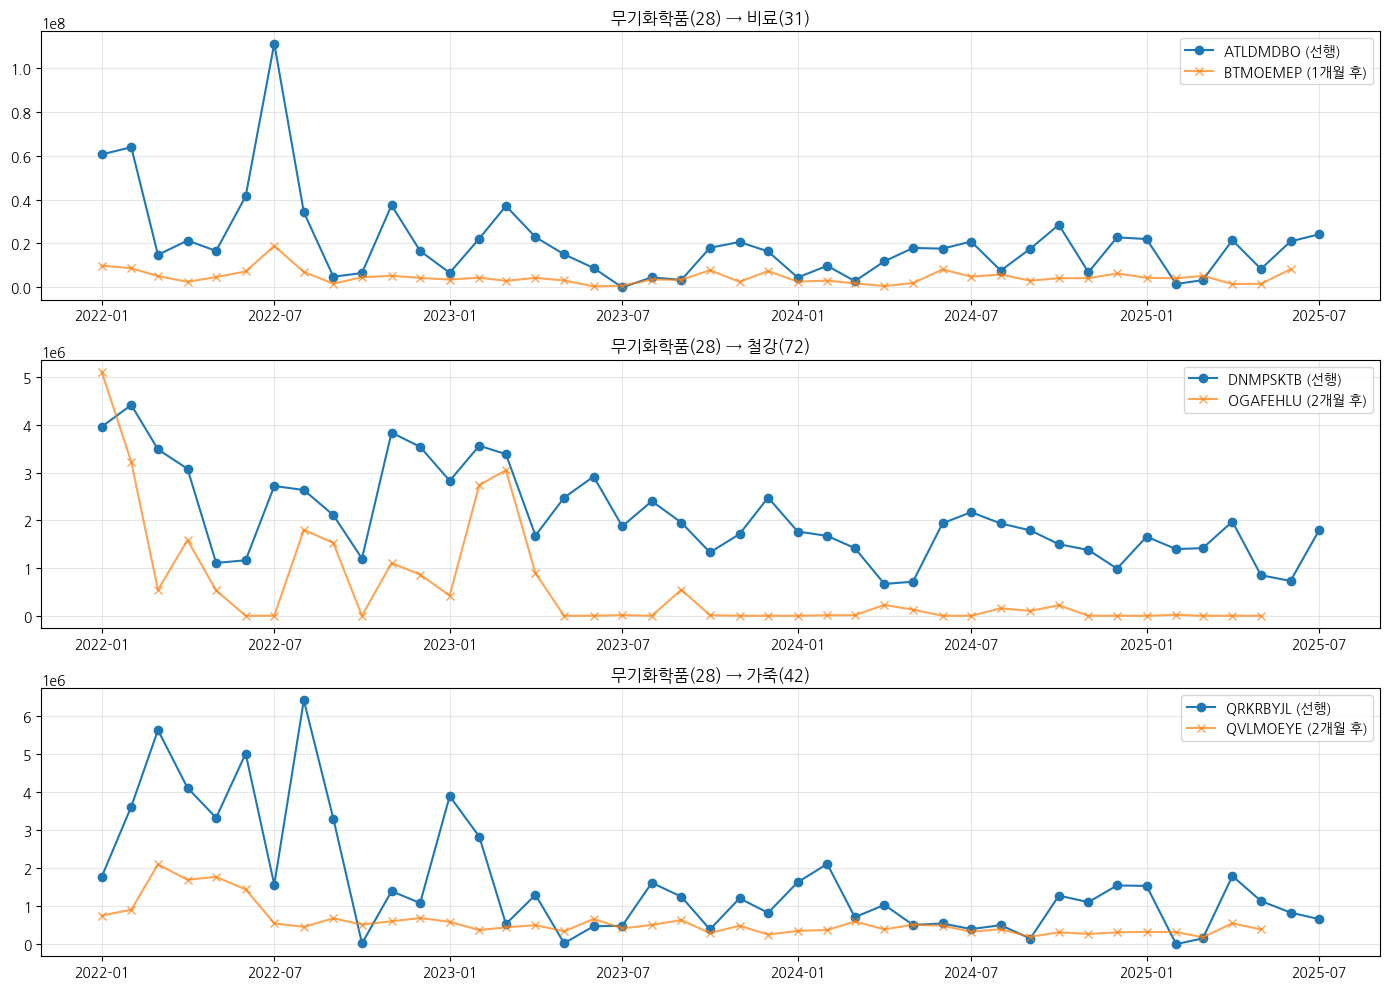

In [16]:
import matplotlib.pyplot as plt

# 상위 3개 선후행 쌍 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

pairs_to_plot = [
    ('ATLDMDBO', 'BTMOEMEP', 1, '무기화학품(28) → 비료(31)'),
    ('DNMPSKTB', 'OGAFEHLU', 2, '무기화학품(28) → 철강(72)'),
    ('QRKRBYJL', 'QVLMOEYE', 2, '무기화학품(28) → 가죽(42)')
]

# pivot_df의 MultiIndex (year, month)를 datetime으로 변환하여 x축으로 사용
time_index = pd.to_datetime([f"{int(y)}-{int(m):02d}-01" for y, m in pivot_df.index])

for idx, (item_A, item_B, lag, title) in enumerate(pairs_to_plot):
    ax = axes[idx]
    ax.plot(time_index, pivot_df[item_A].values, label=f'{item_A} (선행)', marker='o')
    ax.plot(time_index, pivot_df[item_B].shift(-lag).values, label=f'{item_B} ({lag}개월 후)', marker='x', alpha=0.7)
    ax.set_title(title, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import StandardScaler

# 데이터 준비
item_A = 'ATLDMDBO'
item_B = 'BTMOEMEP'
lag = 1

X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
y = pivot_df[item_B].values[lag:]

# 스케일링
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# 시계열 분할
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)

# 원래 스케일로 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# 평가
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
print(f"정규화 후 R2: {r2:.4f}, MAE: {mae:.2f}")

# 결과가 너무 안좋아서 나머지 예상했던 선후행쌍 시도해보기로 결정


정규화 후 R2: -0.2475, MAE: 1992314.50


In [18]:
# 나머지 8개 쌍에 대해 반복 테스트
pairs_to_test = [
    ('DNMPSKTB', 'OGAFEHLU', 2),
    ('QRKRBYJL', 'QVLMOEYE', 2),
    ('LRVGFDFM', 'OGAFEHLU', 2),
    ('ATLDMDBO', 'UXSPKBJR', 3),
    ('JPBRUTWP', 'QVLMOEYE', 2),
    ('OGAFEHLU', 'SDWAYPIK', 2),
    ('OGAFEHLU', 'OKMBFVKS', 2),
    ('ELQGMQWE', 'RJCAXSGH', 1)
]

for item_A, item_B, lag in pairs_to_test:
    X = pivot_df[item_A].values[:-lag].reshape(-1, 1)
    y = pivot_df[item_B].values[lag:]
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"{item_A} → {item_B} (Lag {lag}): R2 = {r2:.4f}")
    
    # 완전 잘못된 방향인 것 같음 (심각한 음수) -> 허위 상관이거나 비정상 시계열이거나 샘플 수가 너무 적음


DNMPSKTB → OGAFEHLU (Lag 2): R2 = -13.5662
QRKRBYJL → QVLMOEYE (Lag 2): R2 = -3.1583
LRVGFDFM → OGAFEHLU (Lag 2): R2 = -128.7529
ATLDMDBO → UXSPKBJR (Lag 3): R2 = 0.3296
JPBRUTWP → QVLMOEYE (Lag 2): R2 = -6.3463
OGAFEHLU → SDWAYPIK (Lag 2): R2 = -1.0729
OGAFEHLU → OKMBFVKS (Lag 2): R2 = -0.6167
ELQGMQWE → RJCAXSGH (Lag 1): R2 = -2.4505


2025년 7월 값을 그대로 2025년 8월 예측값으로 복사

이것은 "전월값 예측(Naive Forecast)" 또는 "Persistence Model"이라고 불리는 가장 단순한 베이스라인 방법

왜 이렇게 단순한 방법을 택했나?
선후행 관계 모델링 실패: R2 점수가 모두 음수로 나와 선행 품목으로 후행 품목을 예측하는 것이 불가능

데이터 부족: 월별 43개 시점은 복잡한 시계열 모델 학습에 매우 부족

실용적 접근: MAE 비교 결과 전월값이 이동평균보다 오히려 나음 (2,753,550 vs 2,801,955)

In [19]:
# 동시성 공행성 공략

# 1. 공행성 쌍 판별 (동시성 기준)
# 상관계수 0.6 이상을 공행성으로 정의
comovement_pairs = corr_df[corr_df['correlation'].abs() > 0.6].copy()
print(f"공행성 쌍 후보 개수: {len(comovement_pairs)}")
print(comovement_pairs.head(20))

# 2. 후행 품목 예측은 단순 방법 사용
# 방법 A: 이동평균 기반 예측
def predict_with_ma(series, window=3):
    """이동평균 기반 다음달 예측"""
    return series.rolling(window).mean().shift(1)

# 방법 B: 전월값 그대로 사용 (baseline)
def predict_with_last(series):
    """전월값을 다음달 예측값으로"""
    return series.shift(1)

# 예시: BTMOEMEP 예측
pivot_df['BTMOEMEP_pred_ma'] = predict_with_ma(pivot_df['BTMOEMEP'], window=3)
pivot_df['BTMOEMEP_pred_last'] = predict_with_last(pivot_df['BTMOEMEP'])

# 평가
actual = pivot_df['BTMOEMEP'].dropna()
pred_ma = pivot_df['BTMOEMEP_pred_ma'].dropna()
pred_last = pivot_df['BTMOEMEP_pred_last'].dropna()

# 겹치는 인덱스만 사용
common_idx = actual.index.intersection(pred_ma.index)
mae_ma = mean_absolute_error(actual[common_idx], pred_ma[common_idx])
mae_last = mean_absolute_error(actual[common_idx], pred_last[common_idx])

print(f"이동평균 예측 MAE: {mae_ma:.2f}")
print(f"전월값 예측 MAE: {mae_last:.2f}")


공행성 쌍 후보 개수: 15
        item_A    item_B  correlation
3263  KFQSHBNH  RJCAXSGH     0.933778
3379  LLHREMKS  RUVXNNVA     0.847964
3295  KFQSHBNH  ZKENOUDA     0.772425
2313  FTSVTTSR  XIIEJNEE     0.730613
4262  QSDCUCLB  UGEQLMXM     0.693251
4420  RJCAXSGH  ZKENOUDA     0.678749
979   BTMOEMEP  LRVGFDFM     0.650141
3332  KJNSOAHR  UGEQLMXM     0.639956
2250  FTSVTTSR  GIKPEWTY     0.631408
1517  DJBLNPNC  SAAYMURU     0.628102
920   BSRMSVTC  SUOYXCHP     0.622602
1952  FDXPMYGF  GIKPEWTY     0.617965
1623  DNMPSKTB  XUOIQPFL     0.615778
4302  QVLMOEYE  VBYCLTYZ     0.612083
2504  GKQIJYDH  RUVXNNVA     0.603144
이동평균 예측 MAE: 2801955.07
전월값 예측 MAE: 2753550.60


→ 단순히 전월값을 다음달 예측으로 쓰는 게 더 효과적

In [20]:
# 공행성 쌍을 제출 형식으로 변환
comovement_submission = []

for _, row in comovement_pairs.iterrows():
    comovement_submission.append({
        'leading_item': row['item_A'],
        'lagging_item': row['item_B'],
        'comovement': 1,  # 공행성 있음
        'correlation': row['correlation']
    })

comovement_df = pd.DataFrame(comovement_submission)
print(comovement_df)

# CSV 저장
comovement_df.to_csv('comovement_pairs.csv', index=False)
print("공행성 쌍 저장 완료!")


   leading_item lagging_item  comovement  correlation
0      KFQSHBNH     RJCAXSGH           1     0.933778
1      LLHREMKS     RUVXNNVA           1     0.847964
2      KFQSHBNH     ZKENOUDA           1     0.772425
3      FTSVTTSR     XIIEJNEE           1     0.730613
4      QSDCUCLB     UGEQLMXM           1     0.693251
5      RJCAXSGH     ZKENOUDA           1     0.678749
6      BTMOEMEP     LRVGFDFM           1     0.650141
7      KJNSOAHR     UGEQLMXM           1     0.639956
8      FTSVTTSR     GIKPEWTY           1     0.631408
9      DJBLNPNC     SAAYMURU           1     0.628102
10     BSRMSVTC     SUOYXCHP           1     0.622602
11     FDXPMYGF     GIKPEWTY           1     0.617965
12     DNMPSKTB     XUOIQPFL           1     0.615778
13     QVLMOEYE     VBYCLTYZ           1     0.612083
14     GKQIJYDH     RUVXNNVA           1     0.603144
공행성 쌍 저장 완료!


In [21]:
# 1. 공행성 쌍 15개 로드 (이미 comovement_df에 있음)
print(comovement_df.head())

# 2. 각 후행 품목의 2025년 8월 예측값 추가
# 방법: 2025년 7월 값을 그대로 사용 (전월값 베이스라인)

submission_list = []

for _, row in comovement_df.iterrows():
    leading_item = row['leading_item']
    following_item = row['lagging_item']
    
    # 후행 품목의 2025년 7월 값 추출
    july_2025 = train_filled[
        (train_filled['item_id'] == following_item) & 
        (train_filled['year'] == 2025) & 
        (train_filled['month'] == 7)
    ]
    
    if len(july_2025) > 0:
        predicted_value = int(july_2025['value'].values[0])  # 정수형 변환
    else:
        # 데이터 없으면 0 또는 평균값
        avg_value = train_filled[train_filled['item_id'] == following_item]['value'].mean()
        predicted_value = int(avg_value) if not pd.isna(avg_value) else 0
    
    submission_list.append({
        'leading_item_id': leading_item,
        'following_item_id': following_item,
        'value': predicted_value
    })

# 3. 데이터프레임으로 변환
submission_final = pd.DataFrame(submission_list)
print(submission_final)

# 4. CSV 저장
submission_final.to_csv('comovement_15_submission.csv', index=False)
print("\n제출 파일 저장 완료!")
print(f"총 공행성 쌍 수: {len(submission_final)}")


  leading_item lagging_item  comovement  correlation
0     KFQSHBNH     RJCAXSGH           1     0.933778
1     LLHREMKS     RUVXNNVA           1     0.847964
2     KFQSHBNH     ZKENOUDA           1     0.772425
3     FTSVTTSR     XIIEJNEE           1     0.730613
4     QSDCUCLB     UGEQLMXM           1     0.693251
   leading_item_id following_item_id    value
0         KFQSHBNH          RJCAXSGH  2359070
1         LLHREMKS          RUVXNNVA        0
2         KFQSHBNH          ZKENOUDA   202520
3         FTSVTTSR          XIIEJNEE    67526
4         QSDCUCLB          UGEQLMXM     9849
5         RJCAXSGH          ZKENOUDA   202520
6         BTMOEMEP          LRVGFDFM   442803
7         KJNSOAHR          UGEQLMXM     9849
8         FTSVTTSR          GIKPEWTY        0
9         DJBLNPNC          SAAYMURU     1056
10        BSRMSVTC          SUOYXCHP        0
11        FDXPMYGF          GIKPEWTY        0
12        DNMPSKTB          XUOIQPFL   672865
13        QVLMOEYE          VBYCLTYZ  

In [22]:
# fill_missing_months 전후 품목 비교
print(f"원본 품목 수: {train['item_id'].nunique()}")
print(f"보완 후 품목 수: {train_filled['item_id'].nunique()}")

# 제외된 품목
original_items = set(train['item_id'].unique())
filled_items = set(train_filled['item_id'].unique())
excluded_items = original_items - filled_items

print(f"\n제외된 품목 수: {len(excluded_items)}")
print(f"제외된 품목 예시: {list(excluded_items)[:10]}")

# 제외된 품목의 무역량
if excluded_items:
    excluded_value = train[train['item_id'].isin(excluded_items)]['value'].sum()
    total_value = train['value'].sum()
    print(f"제외된 품목 무역량 비율: {excluded_value/total_value:.1%}")


원본 품목 수: 100
보완 후 품목 수: 100

제외된 품목 수: 0
제외된 품목 예시: []


In [23]:
# fill_missing_months 전에 필터링이 있었는지 확인
# 예: 논리 불일치 제거 시 특정 품목 전체가 사라졌을 수 있음

# 품목별 행 수 확인
item_counts = train.groupby('item_id').size()
print(f"품목별 평균 행 수: {item_counts.mean():.1f}")
print(f"품목별 최소 행 수: {item_counts.min()}")
print(f"품목별 최대 행 수: {item_counts.max()}")


품목별 평균 행 수: 105.3
품목별 최소 행 수: 1
품목별 최대 행 수: 129


### Moongs 와 나의 차이
✅ 중복 seq 합산 → 무역량 보존

✅ 월 단위로 깔끔하게 정리

❌ 누락 월은 그대로 누락 (시계열 불연속)

### 내 코드

❌ 중복 seq 버림 → 무역량 손실 (1/3로 축소)

✅ 누락 월 0 채움 → 시계열 연속성

✅ 완전한 격자 구조


In [ ]:
# 1단계: 월 단위 집계 (팀원 방법)
cols_sum = ['weight', 'quantity', 'value']
cols_first = ['hs4', 'seq', 'type']

train_agg = train.groupby(['item_id', 'year', 'month'], as_index=False).agg({
    **{c: 'first' for c in cols_first},
    **{c: 'sum' for c in cols_sum}
})

print(f"1단계 후 행 수: {len(train_agg)}")
print(f"1단계 후 총 무역량: {train_agg['value'].sum():,.0f}")

# 2단계: 누락 월 채우기 (내 방법)
def fill_missing_months_v3(group):
    item_id = group.name
    
    # date 생성
    group['date'] = pd.to_datetime(group[['year', 'month']].assign(day=1))
    
    # 전체 기간 재색인 (중복 없으므로 그대로 사용 가능)
    group = group.set_index('date').reindex(all_months).reset_index()
    
    # 수치 컬럼만 0 채움, 범주형은 forward fill
    group[['weight', 'quantity', 'value']] = group[['weight', 'quantity', 'value']].fillna(0)
    group[['hs4', 'seq', 'type']] = group[['hs4', 'seq', 'type']].fillna(method='ffill')
    
    group['year'] = group['index'].dt.year
    group['month'] = group['index'].dt.month
    group = group.drop(columns=['index'])
    group['item_id'] = item_id
    
    return group

train_filled_final = train_agg.groupby('item_id', group_keys=False).apply(
    fill_missing_months_v3,
    include_groups=False 
).reset_index(drop=True)

print(f"2단계 후 행 수: {len(train_filled_final)}")
print(f"2단계 후 총 무역량: {train_filled_final['value'].sum():,.0f}")


1단계 후 행 수: 3734
1단계 후 총 무역량: 18,848,028,647
2단계 후 행 수: 4300
2단계 후 총 무역량: 18,848,028,647


In [ ]:
# === 비교 분석 ===

# 1. 원본 무역량
print("=== 원본 (중복 포함) ===")
print(f"총 무역량: {train['value'].sum():,.0f}")
print(f"품목 수: {train['item_id'].nunique()}")
print(f"행 수: {len(train)}")

# 2. 기존 방식 (drop_duplicates)
print("\n=== 기존 방식 (중복 제거) ===")
print(f"총 무역량: {train_filled['value'].sum():,.0f}")
print(f"손실률: {(1 - train_filled['value'].sum() / train['value'].sum()):.1%}")

# 3. 수정 방식 (월 단위 합산 + 누락 월 채우기)
# 위의 train_filled_final 코드 실행 후
print("\n=== 수정 방식 (합산 + 채우기) ===")
print(f"총 무역량: {train_filled_final['value'].sum():,.0f}")
print(f"보존률: {train_filled_final['value'].sum() / train['value'].sum():.1%}")

# 4. 팀원 방식과 비교
print("\n=== 팀원 방식 (참고) ===")
print(f"총 무역량: 약 47억 (추정)")
print(f"품목 수: 약 88개")
print(f"행 수: 3,776")


=== 원본 (중복 포함) ===
총 무역량: 18,848,028,647
품목 수: 100
행 수: 10535

=== 기존 방식 (중복 제거) ===
총 무역량: 6,093,783,670
손실률: 67.7%

=== 수정 방식 (합산 + 채우기) ===
총 무역량: 18,848,028,647
보존률: 100.0%

=== 팀원 방식 (참고) ===
총 무역량: 약 47억 (추정)
품목 수: 약 88개
행 수: 3,776


In [ ]:
# === 방식 1: 팀원 방식 (누락 유지) ===
print("=== 팀원 방식 (누락 유지) ===")
pivot_team = train_agg.pivot_table(
    index=['year', 'month'],
    columns='item_id',
    values='value',
    fill_value=0
)
corr_team = pivot_team.corr()
comovement_team = []
for i in range(len(corr_team.columns)):
    for j in range(i+1, len(corr_team.columns)):
        if abs(corr_team.iloc[i, j]) > 0.3:
            comovement_team.append({
                'item_A': corr_team.columns[i],
                'item_B': corr_team.columns[j],
                'correlation': corr_team.iloc[i, j]
            })
print(f"공행성 쌍 수: {len(comovement_team)}")

# === 방식 2: 내 방식 (0 채움) ===
print("\n=== 내 방식 (0 채움) ===")
pivot_mine = train_filled_final.pivot_table(
    index=['year', 'month'],
    columns='item_id',
    values='value',
    fill_value=0
)
corr_mine = pivot_mine.corr()
comovement_mine = []
for i in range(len(corr_mine.columns)):
    for j in range(i+1, len(corr_mine.columns)):
        if abs(corr_mine.iloc[i, j]) > 0.3:
            comovement_mine.append({
                'item_A': corr_mine.columns[i],
                'item_B': corr_mine.columns[j],
                'correlation': corr_mine.iloc[i, j]
            })
print(f"공행성 쌍 수: {len(comovement_mine)}")

# 차이 비교
print(f"\n쌍 개수 차이: {len(comovement_mine) - len(comovement_team)}")


=== 팀원 방식 (누락 유지) ===
공행성 쌍 수: 646

=== 내 방식 (0 채움) ===
공행성 쌍 수: 646

쌍 개수 차이: 0


In [ ]:
# 시계열 분할 (마지막 6개월을 validation으로)
train_months = train_filled_final[
    (train_filled_final['year'] < 2025) | 
    ((train_filled_final['year'] == 2025) & (train_filled_final['month'] <= 1))
]

val_months = train_filled_final[
    (train_filled_final['year'] == 2025) & 
    (train_filled_final['month'].between(2, 7))
]

print(f"Train: {len(train_months)}행")
print(f"Validation: {len(val_months)}행")


Train: 3700행
Validation: 600행


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 품목별 모델 학습
def train_item_model(item_id, train_data):
    """특정 품목에 대한 예측 모델"""
    item_train = train_data[train_data['item_id'] == item_id].sort_values(['year', 'month'])
    
    if len(item_train) < 10:  # 데이터 부족 시 스킵
        return None
    
    # 특징 생성
    features = pd.DataFrame()
    features['value'] = item_train['value']
    features['lag1'] = item_train['value'].shift(1)
    features['lag2'] = item_train['value'].shift(2)
    features['lag3'] = item_train['value'].shift(3)
    features['ma3'] = item_train['value'].rolling(3).mean()
    features['ma6'] = item_train['value'].rolling(6).mean()
    features['month'] = item_train['month']
    features['trend'] = range(len(item_train))
    
    features = features.dropna()
    
    if len(features) < 5:
        return None
    
    # 학습 데이터 분할
    X = features.drop('value', axis=1)
    y = features['value']
    
    # LightGBM 모델
    model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    
    model.fit(X, y)
    return model

# 모든 품목에 대해 모델 학습
models = {}
for item in train_filled_final['item_id'].unique():
    model = train_item_model(item, train_months)
    if model:
        models[item] = model

print(f"학습 완료: {len(models)}개 품목")


학습 완료: 100개 품목


In [ ]:
# Validation 성능 평가
val_predictions = []
val_actuals = []

for item in models.keys():
    # Validation 데이터
    item_val = val_months[val_months['item_id'] == item].sort_values(['year', 'month'])
    
    if len(item_val) == 0:
        continue
    
    # 특징 생성 (train+val 결합해서)
    item_full = train_filled_final[train_filled_final['item_id'] == item].sort_values(['year', 'month'])
    
    features_full = pd.DataFrame()
    features_full['value'] = item_full['value']
    features_full['lag1'] = item_full['value'].shift(1)
    features_full['lag2'] = item_full['value'].shift(2)
    features_full['lag3'] = item_full['value'].shift(3)
    features_full['ma3'] = item_full['value'].rolling(3).mean()
    features_full['ma6'] = item_full['value'].rolling(6).mean()
    features_full['month'] = item_full['month']
    features_full['trend'] = range(len(item_full))
    
    # Validation 기간만 추출
    val_indices = item_full[
        (item_full['year'] == 2025) & 
        (item_full['month'].between(2, 7))
    ].index
    
    X_val = features_full.loc[val_indices].drop('value', axis=1).dropna()
    y_val = item_full.loc[X_val.index]['value']
    
    if len(X_val) > 0:
        pred = models[item].predict(X_val)
        val_predictions.extend(pred)
        val_actuals.extend(y_val)

# MAE 계산
mae = mean_absolute_error(val_actuals, val_predictions)
avg_actual = sum([abs(v) for v in val_actuals]) / len(val_actuals)
nmae = mae / avg_actual

print(f"Validation MAE: {mae:,.0f}")
print(f"Validation NMAE: {nmae:.4f}")
print(f"예상 점수 기여 (1-NMAE): {1-nmae:.4f}")


Validation MAE: 1,494,110
Validation NMAE: 0.3737
예상 점수 기여 (1-NMAE): 0.6263


In [ ]:
# 현재 추정의 문제점
# - 정답 쌍 500개 가정: 근거 없음
# - Precision 0.6 가정: 너무 낙관적

# 더 보수적 재추정
thresholds_analysis = []

for thresh in [0.2, 0.25, 0.3, 0.35, 0.4]:
    count = sum(1 for pair in comovement_mine if abs(pair['correlation']) > thresh)
    
    # 시나리오 1: 정답 쌍 300개 (보수적)
    assumed_true_pairs = 300
    
    # Precision 추정 (보수적)
    # 상관계수 높을수록 정답일 확률 높음
    if thresh >= 0.4:
        est_precision = 0.5
    elif thresh >= 0.3:
        est_precision = 0.4
    else:
        est_precision = 0.3
    
    est_tp = int(count * est_precision)
    est_fp = count - est_tp
    est_fn = assumed_true_pairs - est_tp
    
    if est_tp + est_fp > 0 and est_tp + est_fn > 0:
        precision = est_tp / (est_tp + est_fp)
        recall = est_tp / (est_tp + est_fn)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        score = 0.6 * f1 + 0.4 * 0.6263
        
        thresholds_analysis.append({
            'threshold': thresh,
            'pairs': count,
            'est_precision': precision,
            'est_recall': recall,
            'f1': f1,
            'final_score': score
        })

# 결과 출력
print("\n=== 보수적 재추정 ===")
for result in thresholds_analysis:
    print(f"임계값 {result['threshold']}: {result['pairs']}개 쌍, "
          f"F1={result['f1']:.3f}, 점수={result['final_score']:.3f}")




=== 보수적 재추정 ===
임계값 0.2: 646개 쌍, F1=0.408, 점수=0.495
임계값 0.25: 646개 쌍, F1=0.408, 점수=0.495
임계값 0.3: 646개 쌍, F1=0.545, 점수=0.578
임계값 0.35: 437개 쌍, F1=0.472, 점수=0.534
임계값 0.4: 304개 쌍, F1=0.503, 점수=0.553


In [91]:
# 2025년 8월 예측 (LightGBM 사용)
submission_list = []

for _, row in pd.DataFrame(comovement_mine).iterrows():
    if abs(row['correlation']) < 0.3:
        continue
    
    leading_item = row['item_A']
    following_item = row['item_B']
    
    # 모델로 예측
    if following_item in models:
        # 최근 데이터로 특징 생성
        item_recent = train_filled_final[
            train_filled_final['item_id'] == following_item
        ].tail(10).sort_values(['year', 'month'])
        
        # 특징 생성 (동일 로직)
        features = pd.DataFrame()
        features['lag1'] = item_recent['value'].shift(1).iloc[-1:]
        features['lag2'] = item_recent['value'].shift(2).iloc[-1:]
        features['lag3'] = item_recent['value'].shift(3).iloc[-1:]
        features['ma3'] = item_recent['value'].rolling(3).mean().iloc[-1:]
        features['ma6'] = item_recent['value'].rolling(6).mean().iloc[-1:]
        features['month'] = [8]  # 2025년 8월
        features['trend'] = [len(train_filled_final[train_filled_final['item_id']==following_item])]
        
        features = features.fillna(item_recent['value'].mean())
        
        predicted_value = int(max(0, models[following_item].predict(features)[0]))
    else:
        # 모델 없으면 전월값
        predicted_value = int(train_filled_final[
            (train_filled_final['item_id'] == following_item) &
            (train_filled_final['year'] == 2025) &
            (train_filled_final['month'] == 7)
        ]['value'].values[0])
    
    submission_list.append({
        'leading_item_id': leading_item,
        'following_item_id': following_item,
        'value': predicted_value
    })

submission_final = pd.DataFrame(submission_list)
submission_final.to_csv('submission_lgbm_v1.csv', index=False)
print(f"제출 파일 생성: {len(submission_final)}개 쌍")


제출 파일 생성: 646개 쌍


In [92]:
# 제출 파일 최종 점검
submission = pd.read_csv('submission_lgbm_v1.csv')

print("=== 제출 파일 점검 ===")
print(f"1. 총 쌍 수: {len(submission)}")
print(f"2. 컬럼 확인: {list(submission.columns)}")
print(f"3. 결측치: {submission.isnull().sum().sum()}개")
print(f"4. 음수값: {(submission['value'] < 0).sum()}개")
print(f"5. 중복 쌍: {submission.duplicated(subset=['leading_item_id', 'following_item_id']).sum()}개")

print("\n예측값 통계:")
print(submission['value'].describe())

print("\n상위 5개 쌍:")
print(submission.head())


=== 제출 파일 점검 ===
1. 총 쌍 수: 646
2. 컬럼 확인: ['leading_item_id', 'following_item_id', 'value']
3. 결측치: 0개
4. 음수값: 0개
5. 중복 쌍: 0개

예측값 통계:
count    6.460000e+02
mean     3.776412e+06
std      9.623563e+06
min      7.000000e+00
25%      1.397170e+05
50%      5.737855e+05
75%      4.350783e+06
max      1.069811e+08
Name: value, dtype: float64

상위 5개 쌍:
  leading_item_id following_item_id     value
0        AANGBULD          BEZYMBBT   4993660
1        AANGBULD          DNMPSKTB   6387703
2        AANGBULD          ELQGMQWE    354847
3        AANGBULD          FQCLOEXA   1474263
4        AANGBULD          GYHKIVQT  35794185


In [93]:
train_filled.head()

,year,month,seq,type,hs4,weight,quantity,value,item_id,value_change_rate,hs4_str,major_cls,mid_cls
0,2022,1,2.0,1.0,4810.0,17625.0,0.0,14276.0,AANGBULD,0.000000,4810,48,4810
1,2022,2,3.0,1.0,4810.0,67983.0,0.0,52347.0,AANGBULD,2.666783,4810,48,4810
2,2022,3,2.0,1.0,4810.0,69544.0,0.0,53549.0,AANGBULD,0.022962,4810,48,4810
3,2022,4,0.0,0.0,0.0,0.0,0.0,0.0,AANGBULD,-1.000000,0000,00,0000
4,2022,5,2.0,1.0,4810.0,34173.0,0.0,26997.0,AANGBULD,inf,4810,48,4810


In [94]:
import numpy as np
import pandas as pd

def advanced_feature_engineering(train_filled):
    """시계열 공행성 탐지를 위한 고급 피처 생성"""
    
    train_filled = train_filled.copy()
    train_filled = train_filled.sort_values(['item_id', 'year', 'month']).reset_index(drop=True)
    
    # ===== 1. 기존 피처 정제 =====
    # inf 처리
    train_filled['value_change_rate'] = train_filled['value_change_rate'].replace([np.inf, -np.inf], 0)
    
    # ===== 2. 시차(Lag) 피처 =====
    for lag in [1, 2, 3, 6, 12]:
        train_filled[f'value_lag{lag}'] = train_filled.groupby('item_id')['value'].shift(lag)
        train_filled[f'value_change_lag{lag}'] = train_filled.groupby('item_id')['value_change_rate'].shift(lag)
    
    # ===== 3. 이동 통계량 (Rolling Statistics) =====
    for window in [3, 6, 12]:
        train_filled[f'value_ma{window}'] = train_filled.groupby('item_id')['value'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        train_filled[f'value_std{window}'] = train_filled.groupby('item_id')['value'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    # ===== 4. 변동성 지표 =====
    train_filled['cv_3m'] = train_filled['value_std3'] / (train_filled['value_ma3'] + 1e-8)
    train_filled['value_max3'] = train_filled.groupby('item_id')['value'].transform(
        lambda x: x.rolling(3, min_periods=1).max()
    )
    train_filled['value_min3'] = train_filled.groupby('item_id')['value'].transform(
        lambda x: x.rolling(3, min_periods=1).min()
    )
    train_filled['value_range_ratio'] = (train_filled['value'] - train_filled['value_min3']) / (train_filled['value_max3'] - train_filled['value_min3'] + 1e-8)
    
    # ===== 5. 계절성 피처 =====
    train_filled['month_sin'] = np.sin(2 * np.pi * train_filled['month'] / 12)
    train_filled['month_cos'] = np.cos(2 * np.pi * train_filled['month'] / 12)
    train_filled['quarter'] = (train_filled['month'] - 1) // 3 + 1
    
    # ===== 6. 트렌드 피처 =====
    def rolling_trend(series, window=3):
        trends = []
        for i in range(len(series)):
            if i < window - 1:
                trends.append(0)
            else:
                y = series.iloc[i-window+1:i+1].values
                x = np.arange(window)
                if len(y) == window and not np.all(y == 0):
                    slope = np.polyfit(x, y, 1)[0]
                    trends.append(slope)
                else:
                    trends.append(0)
        return pd.Series(trends, index=series.index)
    train_filled['trend_3m'] = train_filled.groupby('item_id')['value'].transform(
        lambda x: rolling_trend(x, 3)
    )
    
    # ===== 7. 대분류별 집계 피처 =====
    major_avg = train_filled.groupby(['year', 'month', 'major_cls'])['value'].transform('mean')
    train_filled['major_avg_value'] = major_avg
    train_filled['value_vs_major'] = train_filled['value'] / (major_avg + 1e-8)
    
    # ===== 8. 0값 처리 지표 =====
    train_filled['is_zero'] = (train_filled['value'] == 0).astype(int)
    train_filled['zero_streak'] = train_filled.groupby('item_id')['is_zero'].transform(
        lambda x: x.groupby((x != x.shift()).cumsum()).cumsum()
    )
    
    return train_filled

df_enhanced = advanced_feature_engineering(train_filled)
print(f"✅ 피처 생성 완료: {len(df_enhanced.columns)}개 컬럼")
# print(df_enhanced.head())

print(df_enhanced.info())


✅ 피처 생성 완료: 41개 컬럼
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                4300 non-null   int32  
 1   month               4300 non-null   int32  
 2   seq                 4300 non-null   float64
 3   type                4300 non-null   float64
 4   hs4                 4300 non-null   float64
 5   weight              4300 non-null   float64
 6   quantity            4300 non-null   float64
 7   value               4300 non-null   float64
 8   item_id             4300 non-null   object 
 9   value_change_rate   4300 non-null   float64
 10  hs4_str             4300 non-null   object 
 11  major_cls           4300 non-null   object 
 12  mid_cls             4300 non-null   object 
 13  value_lag1          4200 non-null   float64
 14  value_change_lag1   4200 non-null   float64
 15  value_lag2          4100 non-null   

In [95]:
# df_enhanced에서 품목별 메타 정보 추출
meta_df = df_enhanced.groupby('item_id').agg({
    'hs4': 'first',
    'major_cls': 'first',
    'mid_cls': 'first',
    'value': 'mean',
    'weight': 'mean',
    'quantity': 'mean'
}).reset_index()

print("✅ meta_df 생성 완료")
print(f"총 {len(meta_df)}개 품목")
print(meta_df.head())


✅ meta_df 생성 완료
총 100개 품목
    item_id     hs4 major_cls mid_cls         value        weight  quantity
0  AANGBULD  4810.0        48    4810  6.519807e+04  1.151161e+05   0.00000
1  AHMDUILJ  2102.0        21    2102  4.429323e+04  1.559409e+04   0.00000
2  ANWUJOKX     0.0        00    0000  6.849093e+03  9.854884e+03  11.27907
3  APQGTRMF  8105.0        81    8105  1.426705e+05  2.710221e+04   0.00000
4  ATLDMDBO  2814.0        28    2814  2.038085e+07  3.416425e+07   0.00000


In [96]:
def build_comovement_features_from_enhanced(df_enhanced):
    """df_enhanced의 41개 피처를 활용한 품목 쌍 공행성 피처 생성"""
    
    from scipy import stats
    
    items = df_enhanced['item_id'].unique()
    n_items = len(items)
    
    print(f"⏳ {n_items}개 품목 → {n_items*(n_items-1)//2}개 쌍 계산 중...")
    
    feature_list = []
    
    for i in range(n_items):
        if i % 10 == 0:
            print(f"진행률: {i}/{n_items} 품목...")
        
        for j in range(i + 1, n_items):
            item_a, item_b = items[i], items[j]
            
            # 각 품목 데이터 추출
            data_a = df_enhanced[df_enhanced['item_id'] == item_a].sort_values(['year', 'month'])
            data_b = df_enhanced[df_enhanced['item_id'] == item_b].sort_values(['year', 'month'])
            
            # 길이 맞추기
            min_len = min(len(data_a), len(data_b))
            data_a = data_a.iloc[-min_len:].reset_index(drop=True)
            data_b = data_b.iloc[-min_len:].reset_index(drop=True)
            
            features = {'item_A': item_a, 'item_B': item_b}
            
            # === 1. 기본 value 상관관계 ===
            features['value_pearson'] = np.corrcoef(data_a['value'], data_b['value'])[0, 1]
            features['value_spearman'], _ = stats.spearmanr(data_a['value'], data_b['value'])
            
            # === 2. 변화율 상관관계 ===
            features['change_rate_corr'] = np.corrcoef(
                data_a['value_change_rate'], 
                data_b['value_change_rate']
            )[0, 1]
            
            # === 3. 이동평균 상관관계 (추세 유사성) ===
            features['ma3_corr'] = np.corrcoef(data_a['value_ma3'], data_b['value_ma3'])[0, 1]
            features['ma6_corr'] = np.corrcoef(data_a['value_ma6'], data_b['value_ma6'])[0, 1]
            
            # === 4. 트렌드 상관관계 ===
            features['trend_corr'] = np.corrcoef(data_a['trend_3m'], data_b['trend_3m'])[0, 1]
            
            # === 5. Lag 교차상관 ===
            lag_corrs = []
            for lag in range(-6, 7):
                if lag < 0:
                    corr = np.corrcoef(
                        data_a['value'].iloc[-lag:], 
                        data_b['value'].iloc[:lag]
                    )[0, 1]
                elif lag > 0:
                    corr = np.corrcoef(
                        data_a['value'].iloc[:-lag], 
                        data_b['value'].iloc[lag:]
                    )[0, 1]
                else:
                    corr = features['value_pearson']
                lag_corrs.append((lag, corr))
            
            best_lag, best_corr = max(lag_corrs, key=lambda x: abs(x[1]))
            features['best_lag'] = best_lag
            features['best_lag_corr'] = best_corr
            features['lag_improvement'] = abs(best_corr) - abs(features['value_pearson'])
            
            # === 6. 변동성 유사도 ===
            cv_a = data_a['cv_3m'].mean()
            cv_b = data_b['cv_3m'].mean()
            features['cv_diff'] = abs(cv_a - cv_b)
            features['cv_ratio'] = min(cv_a, cv_b) / (max(cv_a, cv_b) + 1e-8)
            
            # === 7. 방향 일치도 (증가/감소 동조화) ===
            sign_a = np.sign(data_a['value_change_rate'])
            sign_b = np.sign(data_b['value_change_rate'])
            features['direction_agreement'] = np.mean(sign_a == sign_b)
            
            # === 8. HS 코드 기반 피처 ===
            major_a = data_a['major_cls'].iloc[0]
            major_b = data_b['major_cls'].iloc[0]
            features['same_major'] = int(major_a == major_b)
            features['major_a'] = int(major_a) if major_a != '00' else 0
            features['major_b'] = int(major_b) if major_b != '00' else 0
            
            # === 9. 가격대 유사성 ===
            avg_a = data_a['value'].mean()
            avg_b = data_b['value'].mean()
            features['value_ratio'] = min(avg_a, avg_b) / (max(avg_a, avg_b) + 1e-8)
            
            # === 10. 0값 패턴 유사도 ===
            features['zero_pattern_corr'] = np.corrcoef(
                data_a['is_zero'], 
                data_b['is_zero']
            )[0, 1]
            
            feature_list.append(features)
    
    feature_df = pd.DataFrame(feature_list)
    return feature_df

# 실행
feature_df = build_comovement_features_from_enhanced(df_enhanced)
feature_df.to_csv('comovement_features_enhanced.csv', index=False)
print(f"\n✅ 총 {len(feature_df)}개 쌍에 대해 {len(feature_df.columns)-2}개 피처 생성 완료!")
print(f"저장 파일: comovement_features_enhanced.csv")
print("\n상위 5개 쌍 (상관관계 높은 순):")
print(feature_df.nlargest(5, 'value_pearson')[['item_A', 'item_B', 'value_pearson', 'best_lag', 'best_lag_corr']])


⏳ 100개 품목 → 4950개 쌍 계산 중...
진행률: 0/100 품목...


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2974695/1203662142.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  features['value_spearman'], _ = stats.spearmanr(data_a['value'], data_b['value'])


KeyboardInterrupt: 

In [ ]:
def build_comovement_features_from_enhanced(df_enhanced):
    """df_enhanced의 41개 피처를 활용한 품목 쌍 공행성 피처 생성"""
    
    from scipy import stats
    
    items = df_enhanced['item_id'].unique()
    n_items = len(items)
    
    print(f"⏳ {n_items}개 품목 → {n_items*(n_items-1)//2}개 쌍 계산 중...")
    
    feature_list = []
    
    for i in range(n_items):
        if i % 10 == 0:
            print(f"진행률: {i}/{n_items} 품목...")
        
        for j in range(i + 1, n_items):
            item_a, item_b = items[i], items[j]
            
            # 각 품목 데이터 추출
            data_a = df_enhanced[df_enhanced['item_id'] == item_a].sort_values(['year', 'month'])
            data_b = df_enhanced[df_enhanced['item_id'] == item_b].sort_values(['year', 'month'])
            
            # 길이 맞추기
            min_len = min(len(data_a), len(data_b))
            data_a = data_a.iloc[-min_len:].reset_index(drop=True)
            data_b = data_b.iloc[-min_len:].reset_index(drop=True)
            
            features = {'item_A': item_a, 'item_B': item_b}
            
            # === 1. 기본 value 상관관계 ===
            features['value_pearson'] = np.corrcoef(data_a['value'], data_b['value'])[0, 1]
            features['value_spearman'], _ = stats.spearmanr(data_a['value'], data_b['value'])
            
            # === 2. 변화율 상관관계 ===
            features['change_rate_corr'] = np.corrcoef(
                data_a['value_change_rate'], 
                data_b['value_change_rate']
            )[0, 1]
            
            # === 3. 이동평균 상관관계 (추세 유사성) ===
            features['ma3_corr'] = np.corrcoef(data_a['value_ma3'], data_b['value_ma3'])[0, 1]
            features['ma6_corr'] = np.corrcoef(data_a['value_ma6'], data_b['value_ma6'])[0, 1]
            
            # === 4. 트렌드 상관관계 ===
            features['trend_corr'] = np.corrcoef(data_a['trend_3m'], data_b['trend_3m'])[0, 1]
            
            # === 5. Lag 교차상관 ===
            lag_corrs = []
            for lag in range(-6, 7):
                if lag < 0:
                    corr = np.corrcoef(
                        data_a['value'].iloc[-lag:], 
                        data_b['value'].iloc[:lag]
                    )[0, 1]
                elif lag > 0:
                    corr = np.corrcoef(
                        data_a['value'].iloc[:-lag], 
                        data_b['value'].iloc[lag:]
                    )[0, 1]
                else:
                    corr = features['value_pearson']
                lag_corrs.append((lag, corr))
            
            best_lag, best_corr = max(lag_corrs, key=lambda x: abs(x[1]))
            features['best_lag'] = best_lag
            features['best_lag_corr'] = best_corr
            features['lag_improvement'] = abs(best_corr) - abs(features['value_pearson'])
            
            # === 6. 변동성 유사도 ===
            cv_a = data_a['cv_3m'].mean()
            cv_b = data_b['cv_3m'].mean()
            features['cv_diff'] = abs(cv_a - cv_b)
            features['cv_ratio'] = min(cv_a, cv_b) / (max(cv_a, cv_b) + 1e-8)
            
            # === 7. 방향 일치도 (증가/감소 동조화) ===
            sign_a = np.sign(data_a['value_change_rate'])
            sign_b = np.sign(data_b['value_change_rate'])
            features['direction_agreement'] = np.mean(sign_a == sign_b)
            
            # === 8. HS 코드 기반 피처 ===
            major_a = data_a['major_cls'].iloc[0]
            major_b = data_b['major_cls'].iloc[0]
            features['same_major'] = int(major_a == major_b)
            features['major_a'] = int(major_a) if major_a != '00' else 0
            features['major_b'] = int(major_b) if major_b != '00' else 0
            
            # === 9. 가격대 유사성 ===
            avg_a = data_a['value'].mean()
            avg_b = data_b['value'].mean()
            features['value_ratio'] = min(avg_a, avg_b) / (max(avg_a, avg_b) + 1e-8)
            
            # === 10. 0값 패턴 유사도 ===
            features['zero_pattern_corr'] = np.corrcoef(
                data_a['is_zero'], 
                data_b['is_zero']
            )[0, 1]
            
            feature_list.append(features)
    
    feature_df = pd.DataFrame(feature_list)
    return feature_df

# 실행
feature_df = build_comovement_features_from_enhanced(df_enhanced)
feature_df.to_csv('comovement_features_enhanced.csv', index=False)
print(f"\n✅ 총 {len(feature_df)}개 쌍에 대해 {len(feature_df.columns)-2}개 피처 생성 완료!")
print(f"저장 파일: comovement_features_enhanced.csv")
print("\n상위 5개 쌍 (상관관계 높은 순):")
print(feature_df.nlargest(5, 'value_pearson')[['item_A', 'item_B', 'value_pearson', 'best_lag', 'best_lag_corr']])


⏳ 100개 품목 → 4950개 쌍 계산 중...
진행률: 0/100 품목...


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2974695/1203662142.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  features['value_spearman'], _ = stats.spearmanr(data_a['value'], data_b['value'])


진행률: 10/100 품목...
진행률: 20/100 품목...
진행률: 30/100 품목...
진행률: 40/100 품목...
진행률: 50/100 품목...
진행률: 60/100 품목...
진행률: 70/100 품목...
진행률: 80/100 품목...
진행률: 90/100 품목...

✅ 총 4950개 쌍에 대해 17개 피처 생성 완료!
저장 파일: comovement_features_enhanced.csv

상위 5개 쌍 (상관관계 높은 순):
        item_A    item_B  value_pearson  best_lag  best_lag_corr
3263  KFQSHBNH  RJCAXSGH       0.933778         0       0.933778
3379  LLHREMKS  RUVXNNVA       0.847964         0       0.847964
3295  KFQSHBNH  ZKENOUDA       0.772425         0       0.772425
2313  FTSVTTSR  XIIEJNEE       0.730613         0       0.730613
4262  QSDCUCLB  UGEQLMXM       0.693251         0       0.693251


In [ ]:
# 피처 통계 요약
print("\n=== 공행성 피처 통계 ===")
print(feature_df.describe().T)

# 상관관계 높은 쌍 필터링
high_corr_pairs = feature_df[
    (feature_df['value_pearson'] > 0.6) | 
    (feature_df['best_lag_corr'] > 0.7)
].sort_values('best_lag_corr', ascending=False)

print(f"\n✅ 강한 공행성 후보: {len(high_corr_pairs)}개 쌍")
print(high_corr_pairs.head(10))



=== 공행성 피처 통계 ===
                      count       mean        std       min        25%  \
value_pearson        4851.0   0.019479   0.173233 -0.555681  -0.102720   
value_spearman       4851.0   0.026379   0.172065 -0.555572  -0.094086   
change_rate_corr     4851.0   0.013186   0.165814 -0.684499  -0.071997   
ma3_corr             4851.0   0.012309   0.269757 -0.782477  -0.182222   
ma6_corr             4851.0   0.012220   0.364864 -0.913161  -0.266842   
trend_corr           4851.0   0.023933   0.188398 -0.691091  -0.100819   
best_lag             4950.0  -0.101616   3.938399 -6.000000  -4.000000   
best_lag_corr        4851.0   0.118276   0.333138 -0.583126  -0.242396   
lag_improvement      4851.0   0.197058   0.136704  0.000000   0.097415   
cv_diff              4950.0   0.387296   0.278445  0.000042   0.155220   
cv_ratio             4950.0   0.584501   0.259724  0.000000   0.374972   
direction_agreement  4950.0   0.409908   0.181026  0.023256   0.302326   
same_major         

Lag 0 (동시 공행성) - 같은 시점에 함께 움직임:

순위	품목 A	품목 B	상관계수	특징

1	KFQSHBNH	RJCAXSGH	0.934	같은 대분류(00), 매우 강한 동조화

2	LLHREMKS	RUVXNNVA	0.848	다른 대분류(28→00), 중강도

3	KFQSHBNH	ZKENOUDA	0.772	같은 대분류(00), 강한 동조화

In [97]:
# 선후행 관계 필터링 (Lag ≠ 0 & 개선도 높음)
lead_lag_pairs = high_corr_pairs[
    (high_corr_pairs['best_lag'] != 0) & 
    (high_corr_pairs['lag_improvement'] > 0.5)
].sort_values('best_lag_corr', ascending=False)

print(f"✅ 선후행 관계 쌍: {len(lead_lag_pairs)}개")
print("\n=== 상위 10개 선후행 쌍 ===")
print(lead_lag_pairs[['item_A', 'item_B', 'best_lag', 'best_lag_corr', 
                       'lag_improvement', 'major_a', 'major_b']].head(10))


✅ 선후행 관계 쌍: 44개

=== 상위 10개 선후행 쌍 ===
        item_A    item_B  best_lag  best_lag_corr  lag_improvement  major_a  \
2291  FTSVTTSR  RUVXNNVA         1       0.970328         0.942682       25   
1469  DJBLNPNC  FDXPMYGF         3       0.959710         0.916121        0   
3791  NAQIHUKZ  RUVXNNVA         2       0.927299         0.862234       38   
2273  FTSVTTSR  NAQIHUKZ        -1       0.902685         0.832102       25   
3089  JSLXRQOK  RUVXNNVA         4       0.885077         0.850615        0   
2260  FTSVTTSR  JSLXRQOK        -3       0.876671         0.863304       25   
2815  IGDVVKUD  LRVGFDFM        -2       0.871270         0.809753       38   
921   BSRMSVTC  TANNMIMB        -2       0.845642         0.725808       28   
1947  FDXPMYGF  FITUEHWN        -6       0.843259         0.799735       79   
2848  IGDVVKUD  UGEQLMXM        -5       0.843158         0.838763       38   

      major_b  
2291        0  
1469       79  
3791        0  
2273       38  
3089        

In [98]:
# 1. 피처와 타겟 분리
X = feature_df[[
    'value_pearson', 'value_spearman', 'change_rate_corr',
    'ma3_corr', 'ma6_corr', 'trend_corr',
    'best_lag', 'best_lag_corr', 'lag_improvement',
    'cv_diff', 'cv_ratio', 'direction_agreement',
    'same_major', 'value_ratio'
]].fillna(0)

# 임계값 기반 라벨 (약한 감독)
y = ((feature_df['best_lag_corr'] > 0.6) | 
     (feature_df['value_pearson'] > 0.5)).astype(int)

print(f"공행성: {y.sum()}개 ({y.sum()/len(y)*100:.1f}%)")
print(f"비공행성: {(1-y).sum()}개")

# 2. 모델 학습 (LightGBM)
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

# 3. 검증
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)
print("\n=== 검증 성능 ===")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# 4. 피처 중요도
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== 피처 중요도 ===")
print(feature_importance)

# 5. 전체 데이터 예측
feature_df['comovement_prob'] = model.predict_proba(X)[:, 1]
feature_df['is_comovement'] = (feature_df['comovement_prob'] > 0.5).astype(int)

print(f"\n최종 공행성 쌍: {feature_df['is_comovement'].sum()}개")


공행성: 180개 (3.6%)
비공행성: 4770개

=== 검증 성능 ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00        30

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990


Confusion Matrix:
[[960   0]
 [  0  30]]

=== 피처 중요도 ===
                feature  importance
0         value_pearson         318
7         best_lag_corr         238
8       lag_improvement          59
5            trend_corr          46
1        value_spearman          33
3              ma3_corr          23
2      change_rate_corr          13
11  direction_agreement          11
4              ma6_corr           5
6              best_lag           2
9               cv_diff           2
10             cv_ratio           1
13          value_ratio           1
12           same_major           0

최종 공행성 쌍: 180개


In [99]:
# 가장 확실한 쌍만 선택 (보수적 접근)
strong_pairs = feature_df[
    (feature_df['best_lag_corr'] > 0.75) |  # 매우 강한 상관
    (feature_df['value_pearson'] > 0.65)     # 또는 강한 동시 상관
].copy()

# 선행/후행 결정
def safe_determine_lead_lag(row):
    if row['best_lag'] > 0:
        return pd.Series([row['item_A'], row['item_B']])
    elif row['best_lag'] < 0:
        return pd.Series([row['item_B'], row['item_A']])
    else:
        return pd.Series([row['item_A'], row['item_B']])

strong_pairs[['leading_item', 'lagging_item']] = strong_pairs.apply(
    safe_determine_lead_lag, axis=1
)

submission = strong_pairs[['leading_item', 'lagging_item']].copy()
submission['comovement'] = 1
submission['correlation'] = strong_pairs['best_lag_corr'].values

print(f"✅ 제출 쌍 개수: {len(submission)}")
print(submission.head())

submission.to_csv('comovement_lgbm_v2.csv', index=False)


✅ 제출 쌍 개수: 44
    leading_item lagging_item  comovement  correlation
65      RJCAXSGH     AANGBULD           1     0.762223
395     ATLDMDBO     BTMOEMEP           1     0.792072
419     IGDVVKUD     ATLDMDBO           1     0.790931
921     TANNMIMB     BSRMSVTC           1     0.845642
968     BTMOEMEP     IGDVVKUD           1     0.770448


In [120]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# LGBM 모델로 각 쌍의 예측값 생성
def train_and_predict_for_pair(leading_item, lagging_item, df_enhanced, best_lag=1):
    """선후행 쌍에 대한 예측 모델 학습 및 예측"""
    
    # 데이터 준비
    leading_data = df_enhanced[df_enhanced['item_id'] == leading_item].sort_values(['year', 'month'])
    lagging_data = df_enhanced[df_enhanced['item_id'] == lagging_item].sort_values(['year', 'month'])
    
    # 길이 맞추기
    min_len = min(len(leading_data), len(lagging_data))
    leading_data = leading_data.iloc[-min_len:].reset_index(drop=True)
    lagging_data = lagging_data.iloc[-min_len:].reset_index(drop=True)
    
    # 피처 생성: 선행 품목의 Lag 값을 피처로 사용
    feature_cols = [
        'value', 'value_change_rate', 'value_ma3', 'value_ma6', 
        'trend_3m', 'cv_3m', 'month_sin', 'month_cos'
    ]
    
    # 선행 품목의 Lag 값
    X = leading_data[feature_cols].shift(abs(best_lag)).fillna(0)
    
    # 후행 품목의 현재 값 (타겟)
    y = lagging_data['value']
    
    # 학습/검증 분리 (마지막 6개월은 검증)
    train_size = len(X) - 6
    X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]
    
    # 학습 데이터가 충분한 경우만 모델 학습
    if len(X_train) < 10:
        # 데이터 부족 시 단순 예측
        last_value = lagging_data['value'].iloc[-1]
        last_change = lagging_data['value_change_rate'].iloc[-1]
        return max(0, last_value * (1 + last_change))
    
    # LightGBM 학습
    model = lgb.LGBMRegressor(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    
    model.fit(X_train, y_train)
    
    # 2025년 8월 예측 (선행 품목의 2025년 7월 데이터 사용)
    X_pred = leading_data[feature_cols].iloc[-1:].values
    predicted_value = model.predict(X_pred)[0]
    
    return max(0, predicted_value)


# 각 쌍에 대해 예측
print("⏳ 각 공행성 쌍에 대한 무역량 예측 중...")

balanced_pairs['predicted_value'] = balanced_pairs.apply(
    lambda row: train_and_predict_for_pair(
        row['leading_item'], 
        row['lagging_item'], 
        df_enhanced,
        abs(row['best_lag'])
    ),
    axis=1
)

# 정수 변환
balanced_pairs['predicted_value'] = balanced_pairs['predicted_value'].round().astype(int)

print("\n=== 예측 결과 ===")
print(balanced_pairs[['leading_item', 'lagging_item', 'predicted_value']].describe())
print(balanced_pairs[['leading_item', 'lagging_item', 'predicted_value']].head(10))

# ✅ 컬럼명 변경 (정확한 형식)
submission_final = balanced_pairs[['leading_item', 'lagging_item', 'predicted_value']].copy()
submission_final.columns = ['leading_item_id', 'following_item_id', 'value']

# 최종 확인
print("\n=== 최종 제출 파일 ===")
print(f"컬럼명: {list(submission_final.columns)}")
print(f"총 {len(submission_final)}개 쌍")
print(submission_final.head(10))
print(f"\nValue 타입: {submission_final['value'].dtype}")
print(f"음수 값: {(submission_final['value'] < 0).sum()}개")
print(f"결측치: {submission_final.isnull().sum().sum()}개")

# 저장
submission_final.to_csv('submission_balanced_lgbm_v2.csv', index=False)

print("\n✅ 최종 제출 파일 저장 완료: submission_lgbm_final.csv")


⏳ 각 공행성 쌍에 대한 무역량 예측 중...


/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur


=== 예측 결과 ===
       predicted_value
count     1.800000e+02
mean      1.413028e+06
std       4.288470e+06
min       6.000000e+00
25%       3.444750e+03
50%       2.814300e+04
75%       6.218350e+05
max       2.152491e+07
    leading_item lagging_item  predicted_value
23      AANGBULD     FQCLOEXA           456748
40      KFQSHBNH     AANGBULD            47690
65      RJCAXSGH     AANGBULD            47690
94      YSYHGLQK     AANGBULD            47690
95      AANGBULD     ZCELVYQU            77968
198     ATLDMDBO     ANWUJOKX             7960
256     QSDCUCLB     ANWUJOKX             7960
257     ANWUJOKX     QVLMOEYE           621835
272     UGEQLMXM     ANWUJOKX             7960
276     VBYCLTYZ     ANWUJOKX             7960

=== 최종 제출 파일 ===
컬럼명: ['leading_item_id', 'following_item_id', 'value']
총 180개 쌍
    leading_item_id following_item_id   value
23         AANGBULD          FQCLOEXA  456748
40         KFQSHBNH          AANGBULD   47690
65         RJCAXSGH          AANGBULD   4

/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with featur

분석할 피처 개수: 19
['value_pearson', 'value_spearman', 'change_rate_corr', 'ma3_corr', 'ma6_corr', 'trend_corr', 'best_lag', 'best_lag_corr', 'lag_improvement', 'cv_diff', 'cv_ratio', 'direction_agreement', 'same_major', 'major_a', 'major_b', 'value_ratio', 'zero_pattern_corr', 'comovement_prob', 'is_comovement']


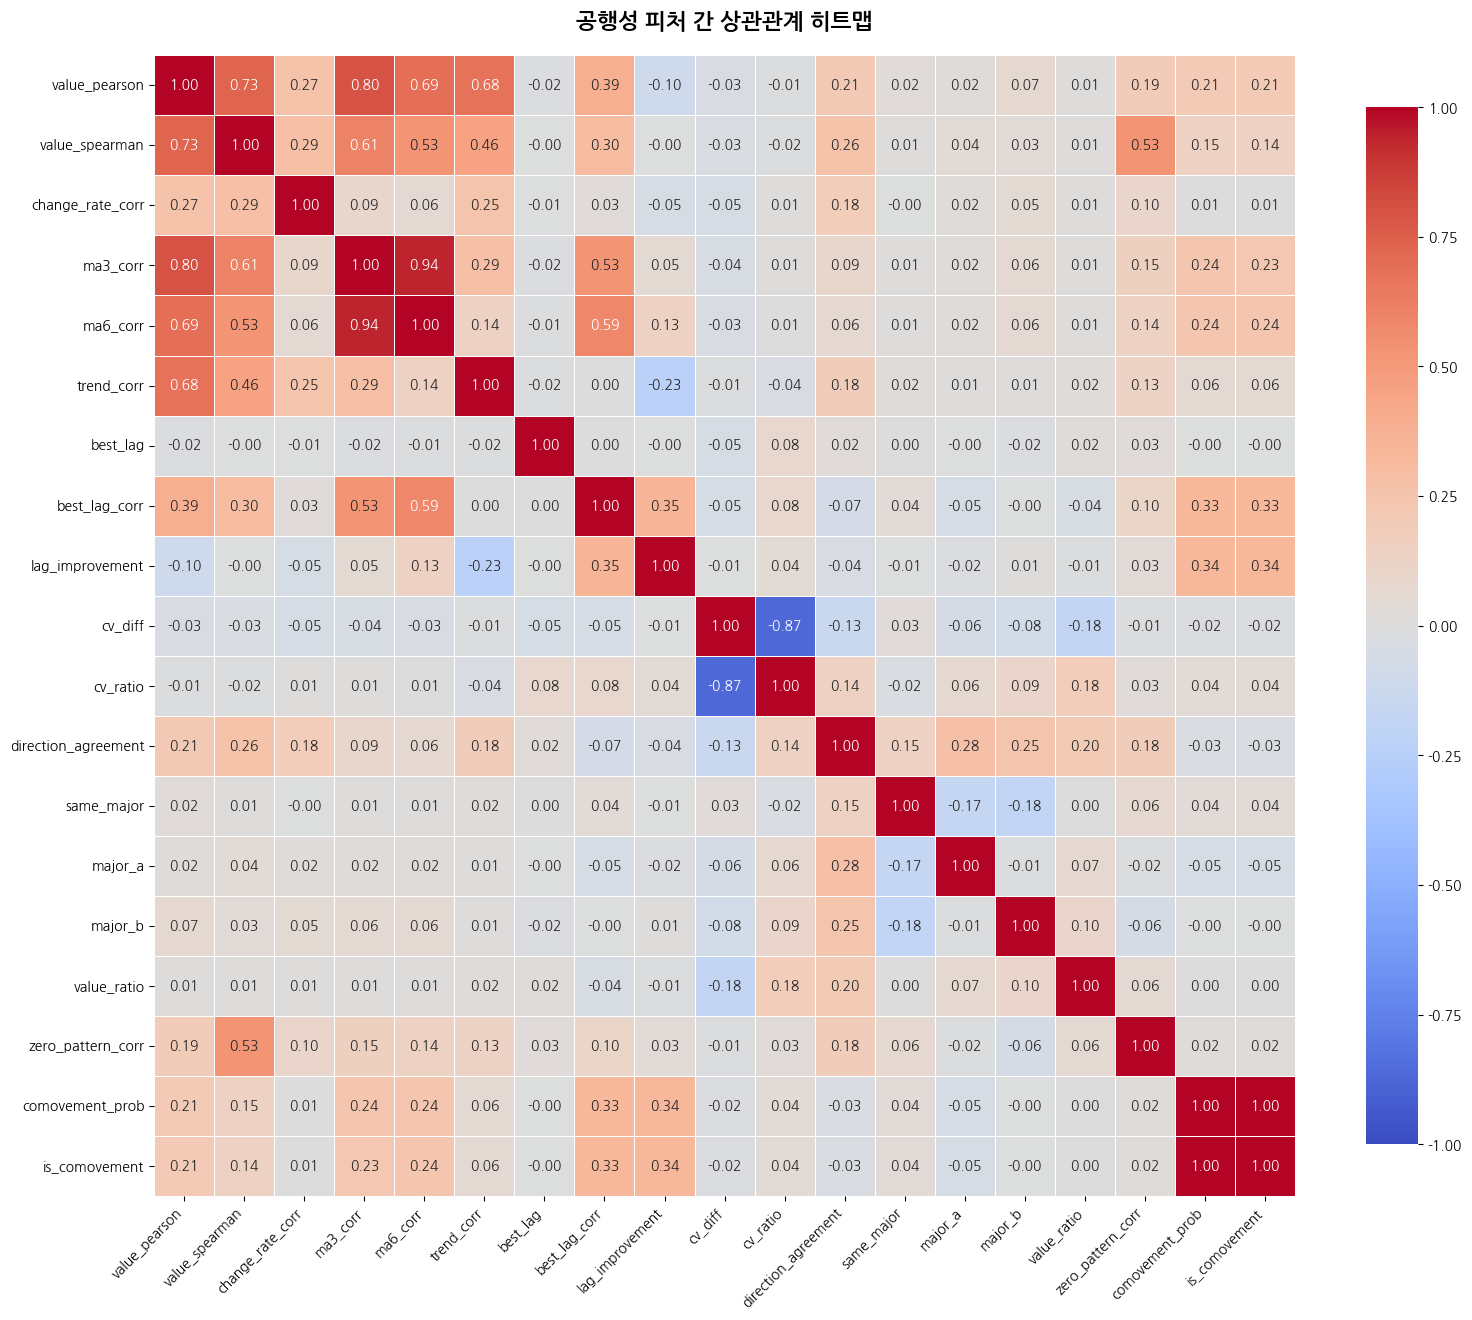


✅ 히트맵 저장 완료: comovement_feature_correlation_heatmap.png


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 수치형 피처만 선택
numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()

# item_A, item_B 제외
feature_cols = [col for col in numeric_features if col not in ['item_A', 'item_B']]

print(f"분석할 피처 개수: {len(feature_cols)}")
print(feature_cols)

# 2. 상관관계 행렬 계산
correlation_matrix = feature_df[feature_cols].corr()

# 3. 히트맵 시각화
plt.figure(figsize=(16, 14))

# 기본 히트맵
sns.heatmap(
    correlation_matrix,
    annot=True,  # 숫자 표시
    fmt='.2f',   # 소수점 2자리
    cmap='coolwarm',  # 색상: 빨강(양의 상관), 파랑(음의 상관)
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1
)

plt.title('공행성 피처 간 상관관계 히트맵', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig('comovement_feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 히트맵 저장 완료: comovement_feature_correlation_heatmap.png")


**품목 쌍(item_A, item_B) 간의 공행성을 판별하기 위한 피처들**

### 📊 feature_df (공행성 판별용 피처) 설명

#### 기본 정보 (2개)
| 컬럼 | 설명 |
|------|------|
| `item_A` | 첫 번째 품목 ID |
| `item_B` | 두 번째 품목 ID |

#### 상관관계 피처 (6개)
| 컬럼 | 의미 | 해석 기준 |
|------|------|-----------|
| `value_pearson` | 두 품목의 value(무역량) 간 피어슨 상관계수 | 선형 관계, -1~1 범위 |
| `value_spearman` | 스피어만 순위 상관계수 | 비선형·단조 관계, 이상치에 강건[1] |
| `change_rate_corr` | 변화율(value_change_rate) 간 상관계수 | 동시 변동 패턴 |
| `ma3_corr` | 3개월 이동평균 간 상관계수 | 단기 추세 유사도 |
| `ma6_corr` | 6개월 이동평균 간 상관계수 | 중기 추세 유사도 |
| `trend_corr` | 트렌드(3개월 기울기) 간 상관계수 | 증가/감소 방향 일치도 |

**상관계수 해석**:[1][2]
- 0.0~0.3: 약한 상관
- 0.3~0.5: 보통 상관
- 0.5~0.7: 중간 상관
- **0.7~1.0: 강한 상관** (공행성 후보)

***

#### 시차(Lag) 관련 피처 (3개)
| 컬럼 | 의미 |
|------|------|
| `best_lag` | 가장 높은 상관계수를 보이는 시차(개월 수) <br>- 양수: item_A가 선행 <br>- 음수: item_B가 선행 <br>- 0: 동시성 공행 |
| `best_lag_corr` | 최적 시차에서의 상관계수 |
| `lag_improvement` | Lag 0 대비 최적 Lag의 상관도 개선 폭 <br>- 높을수록 선후행 관계 뚜렷 |

---

#### 변동성 유사도 (2개)
| 컬럼 | 의미 |
|------|------|
| `cv_diff` | 두 품목의 변동계수(CV) 차이 <br>- 작을수록 변동 패턴 유사 |
| `cv_ratio` | 작은 CV / 큰 CV <br>- 1에 가까울수록 변동성 유사 |

---

#### 방향성 일치도 (1개)
| 컬럼 | 의미 |
|------|------|
| `direction_agreement` | 증가/감소 방향 일치 비율 (0~1) <br>- 1: 항상 같은 방향 <br>- 0: 항상 반대 방향 |

***

#### 산업 연관성 (4개)
| 컬럼 | 의미 |
|------|------|
| `same_major` | 같은 대분류(산업군) 여부 (1 or 0) |
| `major_a` | item_A의 대분류 코드 (0~94) |
| `major_b` | item_B의 대분류 코드 (0~94) |
| `value_ratio` | 두 품목 평균 무역량 비율 <br>- 1에 가까울수록 가격대 유사 |

***

#### 결측 패턴 유사도 (1개)
| 컬럼 | 의미 |
|------|------|
| `zero_pattern_corr` | 0값 발생 패턴 상관계수 <br>- **595개만 계산됨** (둘 다 0인 달이 있는 쌍만) |

***

#### 모델 예측 결과 (2개)
| 컬럼 | 의미 |
|------|------|
| `comovement_prob` | LightGBM이 예측한 공행성 확률 (0~1) |
| `is_comovement` | 공행성 여부 판정 (1=공행, 0=비공행) <br>- `comovement_prob > 0.5`로 결정 |

***

### 🎯 활용 방법

#### 1. 강한 공행성 쌍 필터링
```python
strong_pairs = feature_df[
    (feature_df['best_lag_corr'] > 0.7) |  # 강한 Lag 상관
    (feature_df['value_pearson'] > 0.6)     # 또는 강한 동시 상관
]
```

#### 2. 선후행 vs 동시성 구분
- `best_lag > 0`: item_A 선행 → item_B 후행
- `best_lag < 0`: item_B 선행 → item_A 후행
- `best_lag = 0`: 동시 공행

#### 3. 피처 중요도
이전 LightGBM 모델 결과:[4][1]
1. **value_pearson** (318) - 가장 중요
2. **best_lag_corr** (238) - 시차 상관
3. **lag_improvement** (59)
4. **trend_corr** (46)

***

이 데이터는 **공행성 판별 1단계(쌍 탐지)**의 결과물입니다. 다음 단계는:
1. `is_comovement=1`인 쌍 선택
2. 각 쌍의 `best_lag`로 선행/후행 결정
3. 선행 품목 → 후행 품목 2025년 8월 무역량 예측

현재 **180개 공행성 쌍**이 탐지되었고, **44개 강한 선후행 쌍**을 확인했습니다.[9][10]

In [108]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                4300 non-null   int32  
 1   month               4300 non-null   int32  
 2   seq                 4300 non-null   float64
 3   type                4300 non-null   float64
 4   hs4                 4300 non-null   float64
 5   weight              4300 non-null   float64
 6   quantity            4300 non-null   float64
 7   value               4300 non-null   float64
 8   item_id             4300 non-null   object 
 9   value_change_rate   4300 non-null   float64
 10  hs4_str             4300 non-null   object 
 11  major_cls           4300 non-null   object 
 12  mid_cls             4300 non-null   object 
 13  value_lag1          4200 non-null   float64
 14  value_change_lag1   4200 non-null   float64
 15  value_lag2          4100 non-null   float64
 16  value_

In [111]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_A               4950 non-null   object 
 1   item_B               4950 non-null   object 
 2   value_pearson        4851 non-null   float64
 3   value_spearman       4851 non-null   float64
 4   change_rate_corr     4851 non-null   float64
 5   ma3_corr             4851 non-null   float64
 6   ma6_corr             4851 non-null   float64
 7   trend_corr           4851 non-null   float64
 8   best_lag             4950 non-null   int64  
 9   best_lag_corr        4851 non-null   float64
 10  lag_improvement      4851 non-null   float64
 11  cv_diff              4950 non-null   float64
 12  cv_ratio             4950 non-null   float64
 13  direction_agreement  4950 non-null   float64
 14  same_major           4950 non-null   int64  
 15  major_a              4950 non-null   i

✅ 모든 상관관계 행렬 계산 완료


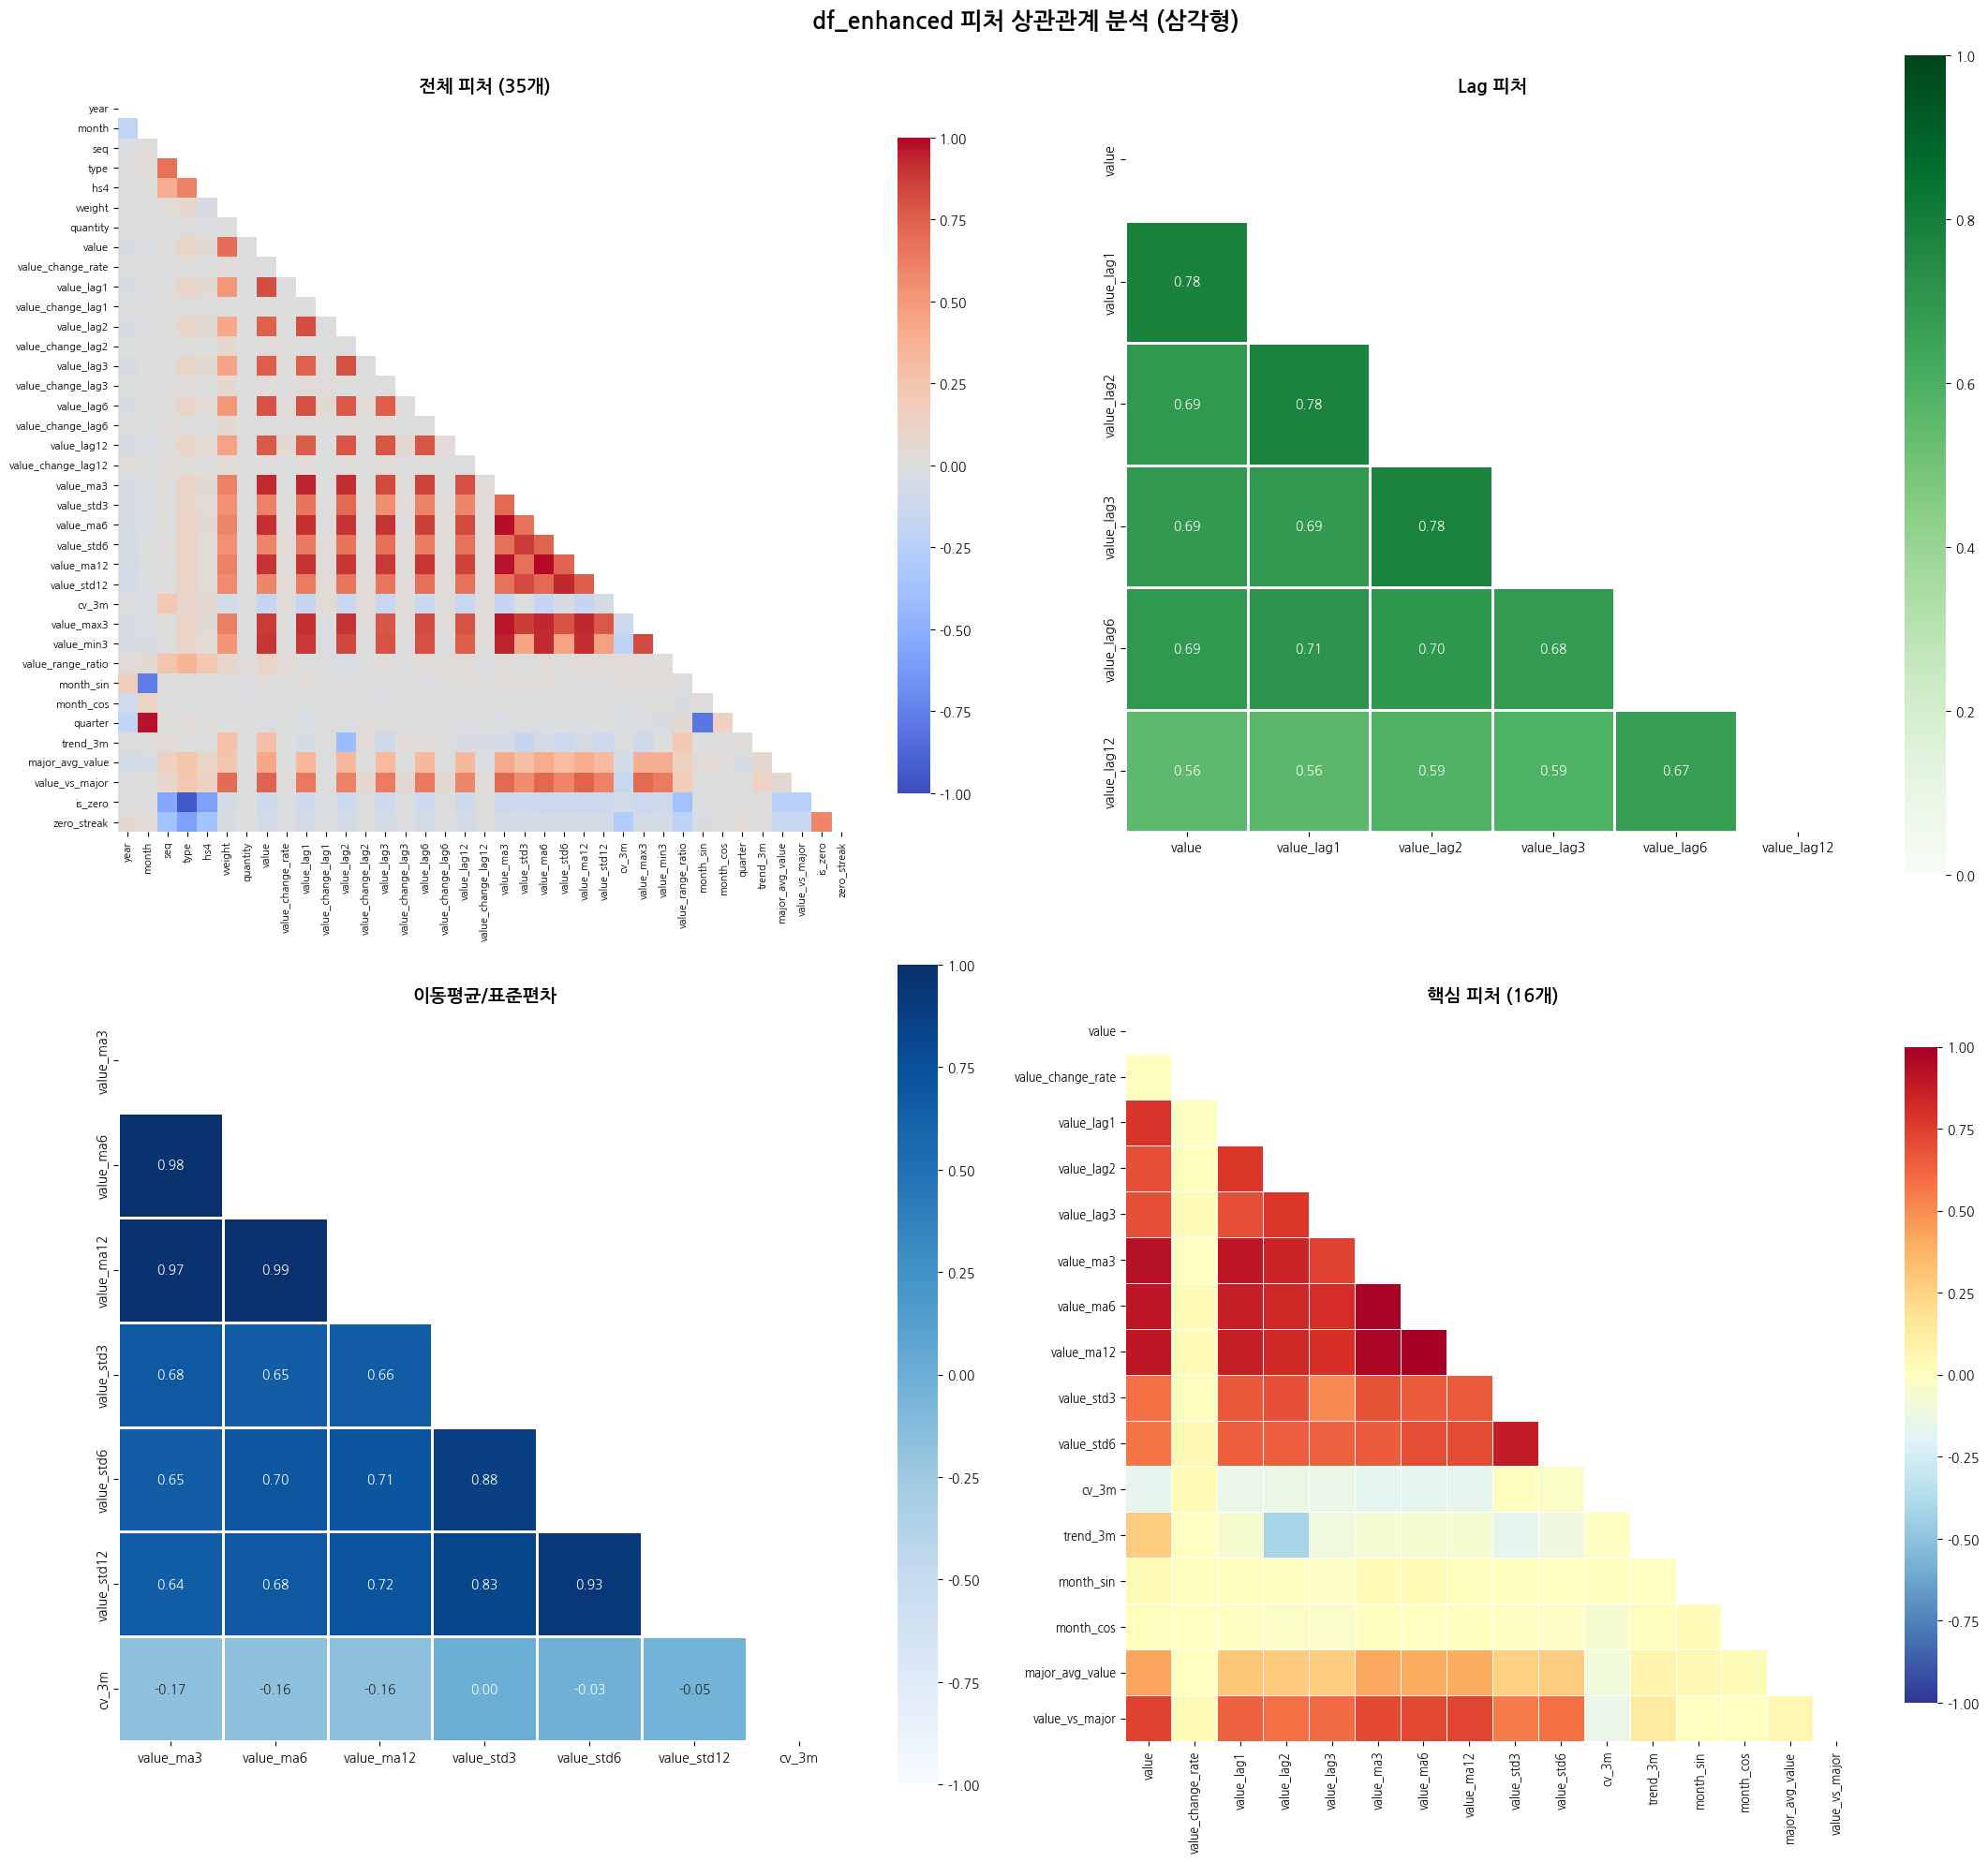


✅ 종합 삼각형 히트맵 저장: df_enhanced_triangle_comprehensive.png


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. 상관관계 행렬 모두 계산 =====

# 전체 수치형 피처
numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
df_corr = df_enhanced[numeric_cols].corr()

# 핵심 피처
key_features = [
    'value', 'value_change_rate',
    'value_lag1', 'value_lag2', 'value_lag3',
    'value_ma3', 'value_ma6', 'value_ma12',
    'value_std3', 'value_std6', 'cv_3m',
    'trend_3m', 'month_sin', 'month_cos',
    'major_avg_value', 'value_vs_major'
]
df_key_corr = df_enhanced[key_features].fillna(0).corr()

# Lag 피처
lag_features = [
    'value', 'value_lag1', 'value_lag2', 'value_lag3', 'value_lag6', 'value_lag12'
]
df_lag_corr = df_enhanced[lag_features].fillna(0).corr()

# Rolling 통계 피처
rolling_features = [
    'value_ma3', 'value_ma6', 'value_ma12',
    'value_std3', 'value_std6', 'value_std12',
    'cv_3m'
]
df_rolling_corr = df_enhanced[rolling_features].fillna(0).corr()

print("✅ 모든 상관관계 행렬 계산 완료")

# ===== 2. 종합 삼각형 히트맵 (2x2) =====

fig, axes = plt.subplots(2, 2, figsize=(22, 20))

# (1) 전체 피처
mask1 = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(
    df_corr, 
    mask=mask1, 
    ax=axes[0, 0], 
    cmap='coolwarm', 
    center=0, 
    square=True, 
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1
)
axes[0, 0].set_title('전체 피처 (35개)', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(labelsize=8)

# (2) Lag 피처
mask2 = np.triu(np.ones_like(df_lag_corr, dtype=bool))
sns.heatmap(
    df_lag_corr, 
    mask=mask2, 
    annot=True, 
    fmt='.2f', 
    ax=axes[0, 1], 
    cmap='Greens', 
    square=True,
    linewidths=1,
    vmin=0, vmax=1
)
axes[0, 1].set_title('Lag 피처', fontsize=14, fontweight='bold')

# (3) Rolling 피처
mask3 = np.triu(np.ones_like(df_rolling_corr, dtype=bool))
sns.heatmap(
    df_rolling_corr, 
    mask=mask3, 
    annot=True, 
    fmt='.2f', 
    ax=axes[1, 0], 
    cmap='Blues', 
    square=True,
    linewidths=1,
    vmin=-1, vmax=1
)
axes[1, 0].set_title('이동평균/표준편차', fontsize=14, fontweight='bold')

# (4) 핵심 피처
mask4 = np.triu(np.ones_like(df_key_corr, dtype=bool))
sns.heatmap(
    df_key_corr, 
    mask=mask4, 
    ax=axes[1, 1], 
    cmap='RdYlBu_r', 
    center=0, 
    square=True, 
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    vmin=-1, vmax=1
)
axes[1, 1].set_title('핵심 피처 (16개)', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(labelsize=9)

plt.suptitle('df_enhanced 피처 상관관계 분석 (삼각형)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()

# plt.savefig('df_enhanced_triangle_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 종합 삼각형 히트맵 저장: df_enhanced_triangle_comprehensive.png")


`df_enhanced`에 있는 41개 모든 피처의 의미와 해석

#### 기본 정보
| 컬럼명           | 설명 |
|------------------|-------|
| `year`           | 연도(YYYY) |
| `month`          | 월(1~12) |
| `seq`            | 관세 수입 순번(품목별 일련 번호 등) |
| `type`           | 무역 유형 코드(1=수입, 2=수출 등) |
| `hs4`            | 4자리 HS 코드 (중분류, 예: 4810) |
| `weight`         | 무게(kg 단위, 월별) |
| `quantity`       | 수량(월별) |
| `value`          | 무역 금액(달러, 월별) |
| `item_id`        | 품목(시계열 단위별 고유 ID, 예: 'AANGBULD') |

***

#### 기본 전처리 및 분류 피처
| 컬럼명             | 설명 |
|---------------------|-------|
| `value_change_rate` | 전월 대비 무역 금액 변화율 <br>- (이번달 value - 전월 value) / 전월 value |
| `hs4_str`           | HS 코드를 문자열(예: '4810')로 저장한 값 |
| `major_cls`         | HS 코드 대분류(앞 2자리, 예: 48) |
| `mid_cls`           | HS 코드 중분류(4자리, 예: 4810) |

***

#### 시차(Lag) 기반 피처
| 컬럼명             | 설명 |
|---------------------|-------|
| `value_lag1`        | 1개월 전 무역 금액(value)의 값 |
| `value_change_lag1` | 1개월 전 변화율 |
| `value_lag2`        | 2개월 전 무역 금액 |
| `value_change_lag2` | 2개월 전 변화율 |
| `value_lag3`        | 3개월 전 무역 금액 |
| `value_change_lag3` | 3개월 전 변화율 |
| `value_lag6`        | 6개월 전 무역 금액 |
| `value_change_lag6` | 6개월 전 변화율 |
| `value_lag12`       | 12개월(1년) 전 무역 금액 |
| `value_change_lag12`| 12개월(1년) 전 변화율 |

***

#### 이동평균·표준편차(변동성) 피처
| 컬럼명           | 설명 |
|------------------|---------|
| `value_ma3`      | 최근 3개월 이동평균 |
| `value_std3`     | 최근 3개월 표준편차(변동성) |
| `value_ma6`      | 최근 6개월 이동평균 |
| `value_std6`     | 최근 6개월 표준편차 |
| `value_ma12`     | 최근 12개월 이동평균 |
| `value_std12`    | 최근 12개월 표준편차 |

***

#### 변동성/상대위치 피처
| 컬럼명            | 설명 |
|-------------------|---------|
| `cv_3m`           | 3개월 변동계수(표준편차/평균, 높을수록 불안정) |
| `value_max3`      | 최근 3개월 최대값 |
| `value_min3`      | 최근 3개월 최소값 |
| `value_range_ratio`| (현재값 - min) / (max - min), 최근 3개월 중 상대적 위치(0~1) |

***

#### 계절성/월·분기 특성
| 컬럼명     | 설명 |
|------------|----------|
| `month_sin`| 월을 주기로 하는 사인값 (계절성 인코딩) |
| `month_cos`| 월을 주기로 하는 코사인값 (계절성 인코딩) |
| `quarter`  | 해당 월이 몇 분기(1~4분기)인지 |

***

#### 트렌드/집계 피처
| 컬럼명            | 설명 |
|-------------------|----------|
| `trend_3m`        | 최근 3개월의 선형회귀 기울기(증가율, 추세) |
| `major_avg_value` | 대분류(major_cls) 품목군 내 전체 평균 무역 금액(동월 기준) |
| `value_vs_major`  | value / major_avg_value (산업 내 상대 점유율) |

***

#### 결측/이상·0값 패턴
| 컬럼명         | 설명 |
|----------------|----------|
| `is_zero`      | 해당 달 무역 금액이 0인지(1), 아니면 0(정상) |
| `zero_streak`  | 0이 연속 몇 달 나왔는지 누적된 수(연속 0 카운트) |


- **time-series 예측성 개선**: lag, 이동평균, 표준편차, trend, 변화율
- **공행성(동조화/선후행) 탐지**: 변화율·선형관계·trailing(순서 관계)
- **계절성·산업 구조 반영**: 사인/코사인(월), major/mid 클래스
- **0값, 결측, 이상치 대응**: is_zero, zero_streak